<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5">ABC Atlas (Yao 2023 Nature)</font>  


See ABC Atlas documentation: https://alleninstitute.github.io/abc_atlas_access/notebooks/10x_snRNASeq_tutorial_part_1.html

This script loads and merges the ABC Atlas on the pseudobulk level. Previously worked on cell-level anndata object (v2,v3,Multi) which has 4M cells and ca. 200 GB. Loading and merging works using cluster memory, but any processing overloads memory (see other script). Possible solutions:
1. Pseudobulking (per sample and celltype) -- best option for DE analysis anyway, see this script
2. RAPIDS-singlecell (GPU accelerated), preliminary set up, see other script
3. Downsampling cells (not implemented)

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
import os
import sys
from datetime import date
from glob import glob
from time import time

import numpy as np
import pandas as pd
import scipy.sparse

In [4]:
import matplotlib.pyplot as plt

In [5]:
import anndata as ad
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [15]:
data_dir = os.path.abspath("../home/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 35 Feb  4 15:06 /home/data -> /dss/dssfs03/pn52re/pn52re-dss-0001


In [16]:
main_dir = os.path.join(data_dir, "P06_cellseg_benchmark")

In [ ]:
os.listdir(
    os.path.join(
        main_dir,
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "download",
        "expression_matrices",
    )
)

# adjust path

# Helper functions

In [10]:
import random


# adapted from https://www.sc-best-practices.org/conditions/differential_gene_expression.html
def pseudobulk_aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i + 1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )

    return adata_cell_pop

# Format cell metadata

Meta data is saved in separate files: load, merge, format

In [11]:
os.listdir(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-10X",
        "20241115",
    )
)

['cell_metadata.csv', 'views', 'gene.csv', 'region_of_interest_metadata.csv']

In [ ]:
cell = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-10X",
        "20241115",
        "cell_metadata.csv",
    ),
    dtype={"cell_label": str},
)
cell.set_index("cell_label", inplace=True)
print("Number of cells = ", len(cell))

In [16]:
cell.shape

(4042976, 16)

In [17]:
cell.head(2)

cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
GCGAGAAGTTAAGGGC-410_B05  GCGAGAAGTTAAGGGC                    410_B05   
AATGGCTCAGCTCCTT-411_B06  AATGGCTCAGCTCCTT                    411_B06   

                               library_label feature_matrix_label entity  \
cell_label                                                                 
GCGAGAAGTTAAGGGC-410_B05  L8TX_201030_01_C12        WMB-10Xv3-HPF   cell   
AATGGCTCAGCTCCTT-411_B06  L8TX_201029_01_E10        WMB-10Xv3-HPF   cell   

                          brain_section_label library_method  \
cell_label                                                     
GCGAGAAGTTAAGGGC-410_B05                  NaN          10Xv3   
AATGGCTCAGCTCCTT-411_B06                  NaN          10Xv3   

                         region_of_interest_acronym  \
cell_label                                            
GCGAGAAGTTAAGGGC-410_B05                        RHP   
AATGGCTCAGCTCCTT-411_B06                        RHP   

                                           donor_label    donor_genotype  \
cell_label                                                                 
GCGAGAAGTTAAGGGC-410_B05  Snap25-IRES2-Cre;Ai14-550850  Ai14(RCL-tdT)/wt   
AATGGCTCAGCTCCTT-411_B06  Snap25-IRES2-Cre;Ai14-550851  Ai14(RCL-tdT)/wt   

                         donor_sex dataset_label          x         y  \
cell_label                                                              
GCGAGAAGTTAAGGGC-410_B05         F     WMB-10Xv3  23.146826 -3.086639   
AATGGCTCAGCTCCTT-411_B06         F     WMB-10Xv3  23.138481 -3.022000   

                          cluster_alias                         abc_sample_id  
cell_label                                                                     
GCGAGAAGTTAAGGGC-410_B05              1  484be5df-5d44-4bfe-9652-7b5bc739c211  
AATGGCTCAGCTCCTT-411_B06              1  5638505d-e1e8-457f-9e5b-59e3e2302417

In [28]:
cell.groupby("dataset_label")[["x"]].count()

x
dataset_label         
WMB-10XMulti      1687
WMB-10Xv2      1699939
WMB-10Xv3      2341350

In [29]:
def print_column_info(df):
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ""
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [30]:
print_column_info(cell)

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

In [31]:
# cell type annotations

In [32]:
os.listdir(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-taxonomy",
        "20231215",
    )
)

['views',
 'cluster.csv',
 'cluster_to_cluster_annotation_membership.csv',
 'cluster_annotation_term.csv',
 'cluster_annotation_term_set.csv']

In [33]:
meta_ct = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-taxonomy",
        "20231215",
        "cluster.csv",
    )
)

In [34]:
meta_ct.shape

(5322, 3)

In [35]:
meta_ct.head(5)

cluster_alias  number_of_cells            label
0              1              727  CS20230722_0001
1             10              740  CS20230722_0010
2            100             1053  CS20230722_0100
3           1000               59  CS20230722_1000
4           1001               96  CS20230722_1001

In [36]:
cluster_details = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-taxonomy",
        "20231215",
        "views",
        "cluster_to_cluster_annotation_membership_pivoted.csv",
    )
)
cluster_details.set_index("cluster_alias", inplace=True)
cluster_details.shape

(5322, 5)

In [37]:
cluster_details.head(5)

neurotransmitter          class                subclass  \
cluster_alias                                                           
1                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
2                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
3                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
4                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
5                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                               supertype                    cluster  
cluster_alias                                                        
1              0082 L2 IT PPP-APr Glut_3  0326 L2 IT PPP-APr Glut_3  
2              0082 L2 IT PPP-APr Glut_3  0327 L2 IT PPP-APr Glut_3  
3              0081 L2 IT PPP-APr Glut_2  0322 L2 IT PPP-APr Glut_2  
4              0081 L2 IT PPP-APr Glut_2  0323 L2 IT PPP-APr Glut_2  
5              0081 L2 IT PPP-APr Glut_2  0325 L2 IT PPP-APr Glut_2

In [38]:
cluster_colors = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-taxonomy",
        "20231215",
        "views",
        "cluster_to_cluster_annotation_membership_color.csv",
    )
)
cluster_colors.set_index("cluster_alias", inplace=True)
cluster_colors.shape

(5322, 5)

In [39]:
cluster_colors.head(5)

neurotransmitter_color class_color subclass_color  \
cluster_alias                                                     
1                            #2B93DF     #FA0087        #0F6632   
2                            #2B93DF     #FA0087        #0F6632   
3                            #2B93DF     #FA0087        #0F6632   
4                            #2B93DF     #FA0087        #0F6632   
5                            #2B93DF     #FA0087        #0F6632   

              supertype_color cluster_color  
cluster_alias                                
1                     #266DFF       #64661F  
2                     #266DFF       #CCA73D  
3                     #002BCC       #99000D  
4                     #002BCC       #5C8899  
5                     #002BCC       #473D66

In [40]:
roi = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-10X",
        "20241115",
        "region_of_interest_metadata.csv",
    )
)
roi.rename(
    columns={
        "order": "region_of_interest_order",
        "color_hex_triplet": "region_of_interest_color",
    },
    inplace=True,
)
roi.set_index("acronym", inplace=True)
roi.shape

(29, 4)

In [41]:
roi.head(5)

label                                    name  \
acronym                                                              
MO-FRP          WMB-MO-FRP              Somatomotor - Frontal pole   
MOp                WMB-MOp                      Primary motor area   
SS-GU-VISC  WMB-SS-GU-VISC  Somatosensory/gustatory/visceral areas   
SSp                WMB-SSp              Primary somatosensory area   
AUD                WMB-AUD                          Auditory areas   

            region_of_interest_order region_of_interest_color  
acronym                                                        
MO-FRP                             0                  #3DCC7C  
MOp                                1                  #179968  
SS-GU-VISC                         2                  #2E8599  
SSp                                3                  #5CCCCC  
AUD                                4                  #455A99

## Merge meta tables

In [42]:
cell_extended = cell.join(cluster_details, on="cluster_alias")
cell_extended = cell_extended.join(cluster_colors, on="cluster_alias")
cell_extended = cell_extended.join(
    roi[["region_of_interest_order", "region_of_interest_color"]],
    on="region_of_interest_acronym",
)
cell_extended.head(2)

cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
GCGAGAAGTTAAGGGC-410_B05  GCGAGAAGTTAAGGGC                    410_B05   
AATGGCTCAGCTCCTT-411_B06  AATGGCTCAGCTCCTT                    411_B06   

                               library_label feature_matrix_label entity  \
cell_label                                                                 
GCGAGAAGTTAAGGGC-410_B05  L8TX_201030_01_C12        WMB-10Xv3-HPF   cell   
AATGGCTCAGCTCCTT-411_B06  L8TX_201029_01_E10        WMB-10Xv3-HPF   cell   

                          brain_section_label library_method  \
cell_label                                                     
GCGAGAAGTTAAGGGC-410_B05                  NaN          10Xv3   
AATGGCTCAGCTCCTT-411_B06                  NaN          10Xv3   

                         region_of_interest_acronym  \
cell_label                                            
GCGAGAAGTTAAGGGC-410_B05                        RHP   
AATGGCTCAGCTCCTT-411_B06                        RHP   

                                           donor_label    donor_genotype  ...  \
cell_label                                                                ...   
GCGAGAAGTTAAGGGC-410_B05  Snap25-IRES2-Cre;Ai14-550850  Ai14(RCL-tdT)/wt  ...   
AATGGCTCAGCTCCTT-411_B06  Snap25-IRES2-Cre;Ai14-550851  Ai14(RCL-tdT)/wt  ...   

                                        subclass                  supertype  \
cell_label                                                                    
GCGAGAAGTTAAGGGC-410_B05  018 L2 IT PPP-APr Glut  0082 L2 IT PPP-APr Glut_3   
AATGGCTCAGCTCCTT-411_B06  018 L2 IT PPP-APr Glut  0082 L2 IT PPP-APr Glut_3   

                                            cluster  neurotransmitter_color  \
cell_label                                                                    
GCGAGAAGTTAAGGGC-410_B05  0326 L2 IT PPP-APr Glut_3                 #2B93DF   
AATGGCTCAGCTCCTT-411_B06  0326 L2 IT PPP-APr Glut_3                 #2B93DF   

                          class_color subclass_color supertype_color  \
cell_label                                                             
GCGAGAAGTTAAGGGC-410_B05      #FA0087        #0F6632         #266DFF   
AATGGCTCAGCTCCTT-411_B06      #FA0087        #0F6632         #266DFF   

                         cluster_color region_of_interest_order  \
cell_label                                                        
GCGAGAAGTTAAGGGC-410_B05       #64661F                       15   
AATGGCTCAGCTCCTT-411_B06       #64661F                       15   

                         region_of_interest_color  
cell_label                                         
GCGAGAAGTTAAGGGC-410_B05                  #CCB05C  
AATGGCTCAGCTCCTT-411_B06                  #CCB05C  

[2 rows x 28 columns]

In [43]:
# format

In [44]:
# categorical for efficiency
cell_extended = cell_extended.apply(
    lambda col: col.astype("category") if col.dtype == "object" else col
)

In [46]:
cell_extended.index.name = None

In [48]:
print_column_info(cell_extended)

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

## Subset

In [51]:
# select cols
cell_extended_subset = cell_extended[
    ["donor_label", "class", "subclass", "neurotransmitter", "library_method"]
]
cell_extended_subset.head()

donor_label          class  \
GCGAGAAGTTAAGGGC-410_B05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   
AATGGCTCAGCTCCTT-411_B06  Snap25-IRES2-Cre;Ai14-550851  01 IT-ET Glut   
AACACACGTTGCTTGA-410_B05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   
CACAGATAGAGGCGGA-410_A05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   
AAAGTGAAGCATTTCG-410_B05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   

                                        subclass neurotransmitter  \
GCGAGAAGTTAAGGGC-410_B05  018 L2 IT PPP-APr Glut             Glut   
AATGGCTCAGCTCCTT-411_B06  018 L2 IT PPP-APr Glut             Glut   
AACACACGTTGCTTGA-410_B05  018 L2 IT PPP-APr Glut             Glut   
CACAGATAGAGGCGGA-410_A05  018 L2 IT PPP-APr Glut             Glut   
AAAGTGAAGCATTTCG-410_B05  018 L2 IT PPP-APr Glut             Glut   

                         library_method  
GCGAGAAGTTAAGGGC-410_B05          10Xv3  
AATGGCTCAGCTCCTT-411_B06          10Xv3  
AACACACGTTGCTTGA-410_B05          10Xv3  
CACAGATAGAGGCGGA-410_A05          10Xv3  
AAAGTGAAGCATTTCG-410_B05          10Xv3

In [52]:
def create_cell_type_dea(meta):
    "format and group cell types labels based on descriptions in paper"

    meta["cell_type_dea"] = meta["subclass"].str.split().str[-1]

    neuron_mask = meta["cell_type_dea"].isin(
        [
            "Gaba",
            "Glut",
            "Gly-Gaba",
            "Dopa-Gaba",
            "Hist-Gaba",
            "Gaba-Glut",
            "Dopa",
            "Glut-Sero",
            "Gaba-Chol",
            "Chol",
            "Glut-Chol",
            "Glyc-Gaba",
        ]
    )
    meta.loc[neuron_mask, "cell_type_dea"] = (
        "Neurons-" + meta.loc[neuron_mask, "cell_type_dea"]
    )

    nn_mask = meta["cell_type_dea"] == "NN"
    meta.loc[nn_mask, "cell_type_dea"] = meta.loc[nn_mask, "subclass"]

    meta["cell_type_dea"] = meta["cell_type_dea"].str.replace(r" NN$", "", regex=True)
    meta["cell_type_dea"] = meta["cell_type_dea"].str.replace(
        r"^\d+\s*", "", regex=True
    )

    replacement_dict = {
        "Astro-TE": "Astrocytes",
        "Astro-NT": "Astrocytes",
        "Astro-OLF": "Astrocytes",
        "Astro-CB": "Astrocytes",
        "Oligo": "Oligodendrocytes",
        "Peri": "Pericytes",
        "Endo": "ECs",
        "VLMC": "VLMCs",
        "ABC": "ABCs",
        "SMC": "SMCs",
        "OPC": "OPCs",
        "OEC": "OECs",
        "Astroependymal": "Ependymal",
        "CHOR": "Ependymal",
        "Tanycyte": "Ependymal",
        "Hypendymal": "Ependymal",
        "Monocytes": "Immune-Other",
        "DC": "Immune-Other",
        "Lymphoid": "Immune-Other",
        "BAM": "BAMs",
        "IMN": "Neurons-Immature",
        "Neurons-Gly-Gaba": "Neurons-Glyc-Gaba",
        "Neurons-Glut-Chol": "Neurons-Other",  # add to Neurons-Other if <4k cells
        "Neurons-Gaba-Glut": "Neurons-Other",
        "Neurons-Chol": "Neurons-Other",
        "Neurons-Hist-Gaba": "Neurons-Other",
        "Neurons-Gaba-Chol": "Neurons-Other",
        "Neurons-Glut-Sero": "Neurons-Other",
    }
    meta["cell_type_dea"] = meta["cell_type_dea"].replace(replacement_dict)

    return meta

In [53]:
cell_meta = create_cell_type_dea(cell_extended_subset)

/tmp/ipykernel_224976/928561799.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["cell_type_dea"] = meta["subclass"].str.split().str[-1]
/tmp/ipykernel_224976/928561799.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["cell_type_dea"] = meta["cell_type_dea"].str.replace(r" NN$", "", regex=True)
/tmp/ipykernel_224976/928561799.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [54]:
cell_meta["cell_type_dea"].value_counts()

Neurons-Glut         2059441
Neurons-Gaba          831856
Oligodendrocytes      422574
Astrocytes            299182
OPCs                  122605
ECs                    88011
Microglia              86232
Neurons-Glyc-Gaba      38492
Pericytes              24907
SMCs                   14614
Neurons-Immature       12755
VLMCs                   9104
Ependymal               6178
Neurons-Other           5660
BAMs                    5626
Neurons-Dopa-Gaba       5406
Neurons-Dopa            4301
Bergmann                3321
OECs                    1132
ABCs                     857
Immune-Other             722
Name: cell_type_dea, dtype: int64

In [55]:
cell_meta["donor_label"].unique()

['Snap25-IRES2-Cre;Ai14-550850', 'Snap25-IRES2-Cre;Ai14-550851', 'Snap25-IRES2-Cre;Ai14-550849', 'Snap25-IRES2-Cre;Ai14-549928', 'Snap25-IRES2-Cre;Ai14-546810', ..., 'C57BL6J-624069', 'C57BL6J-624070', 'C57BL6J-626943', 'C57BL6J-641405', 'C57BL6J-625156']
Length: 345
Categories (345, object): ['C57BL6J-580195', 'C57BL6J-582994', 'C57BL6J-582996', 'C57BL6J-603642', ..., 'Snap25-IRES2-Cre;Ai14-618176', 'Snap25-IRES2-Cre;Ai14-619870', 'Snap25-IRES2-Cre;Ai14-621073', 'Snap25-IRES2-Cre;Ai14-621471']

In [56]:
cell_meta["donor_id"] = cell_meta["donor_label"].str.split("-").str[-1]

/tmp/ipykernel_224976/2731693625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_meta["donor_id"] = cell_meta["donor_label"].str.split("-").str[-1]


In [57]:
assert len(cell_meta["donor_id"].unique()) == len(cell_meta["donor_label"].unique())

In [58]:
cell_meta = cell_meta.drop("donor_label", axis=1)

In [59]:
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [60]:
# del cell_extended
del cluster_details
del cluster_colors
del cell
del meta_ct
del roi
del cell_extended_subset

In [66]:
cell_meta.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        date.today().strftime("%Y%m%d") + "_meta_data_formatted.csv.gz",
    ),
    compression="gzip",
)

## Load gene metadata

In [52]:
gene_meta = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "download",
        "metadata",
        "WMB-10X",
        "20241115",
        "gene.csv",
    )
)
gene_meta.set_index("gene_identifier", inplace=True)
gene_meta = gene_meta.drop(["comment", "mapped_ncbi_identifier", "name"], axis=1)
gene_meta = gene_meta.reset_index().set_index("gene_symbol")
print("Number of genes = ", len(gene_meta))
gene_meta.head(5)

Number of genes =  32285


gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

## Plot UMAP

Does not require matrix - can be run on cell metadata only

In [71]:
def plot_umap(
    xx,
    yy,
    cc=None,
    val=None,
    fig_width=8,
    fig_height=8,
    cmap=None,
    legend_title=None,
    legend_classes=None,
):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None and val is not None:
        scatter = plt.scatter(xx, yy, s=0.5, c=val, marker=".", cmap=cmap)
        plt.colorbar(scatter, ax=ax, label=legend_title)
    elif cc is not None:
        if legend_classes is not None:
            # Create scatter plot with unique colors for each class
            unique_classes = np.unique(legend_classes)
            scatter = plt.scatter(xx, yy, s=0.5, c=cc, marker=".")

            # Create custom legend using legend_classes
            legend_elements = [
                plt.Line2D(
                    [0],
                    [0],
                    marker=".",
                    color="w",
                    label=cls,
                    markerfacecolor=cc[legend_classes == cls][0],
                    markersize=10,
                )
                for cls in unique_classes
            ]
            plt.legend(
                handles=legend_elements,
                title=legend_title or "Cell Classes",
                loc="best",
                markerscale=3,
                bbox_to_anchor=(1.05, 1),
                borderaxespad=0.0,
            )
        else:
            # Fallback to previous behavior if legend_classes is not provided
            scatter = plt.scatter(xx, yy, s=0.5, c=cc, marker=".")

    ax.axis("equal")
    ax.set_xlim(-18, 27)
    ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    return fig, ax

In [72]:
cell_subsampled = cell_extended.loc[::10]
print(len(cell_subsampled))

404298


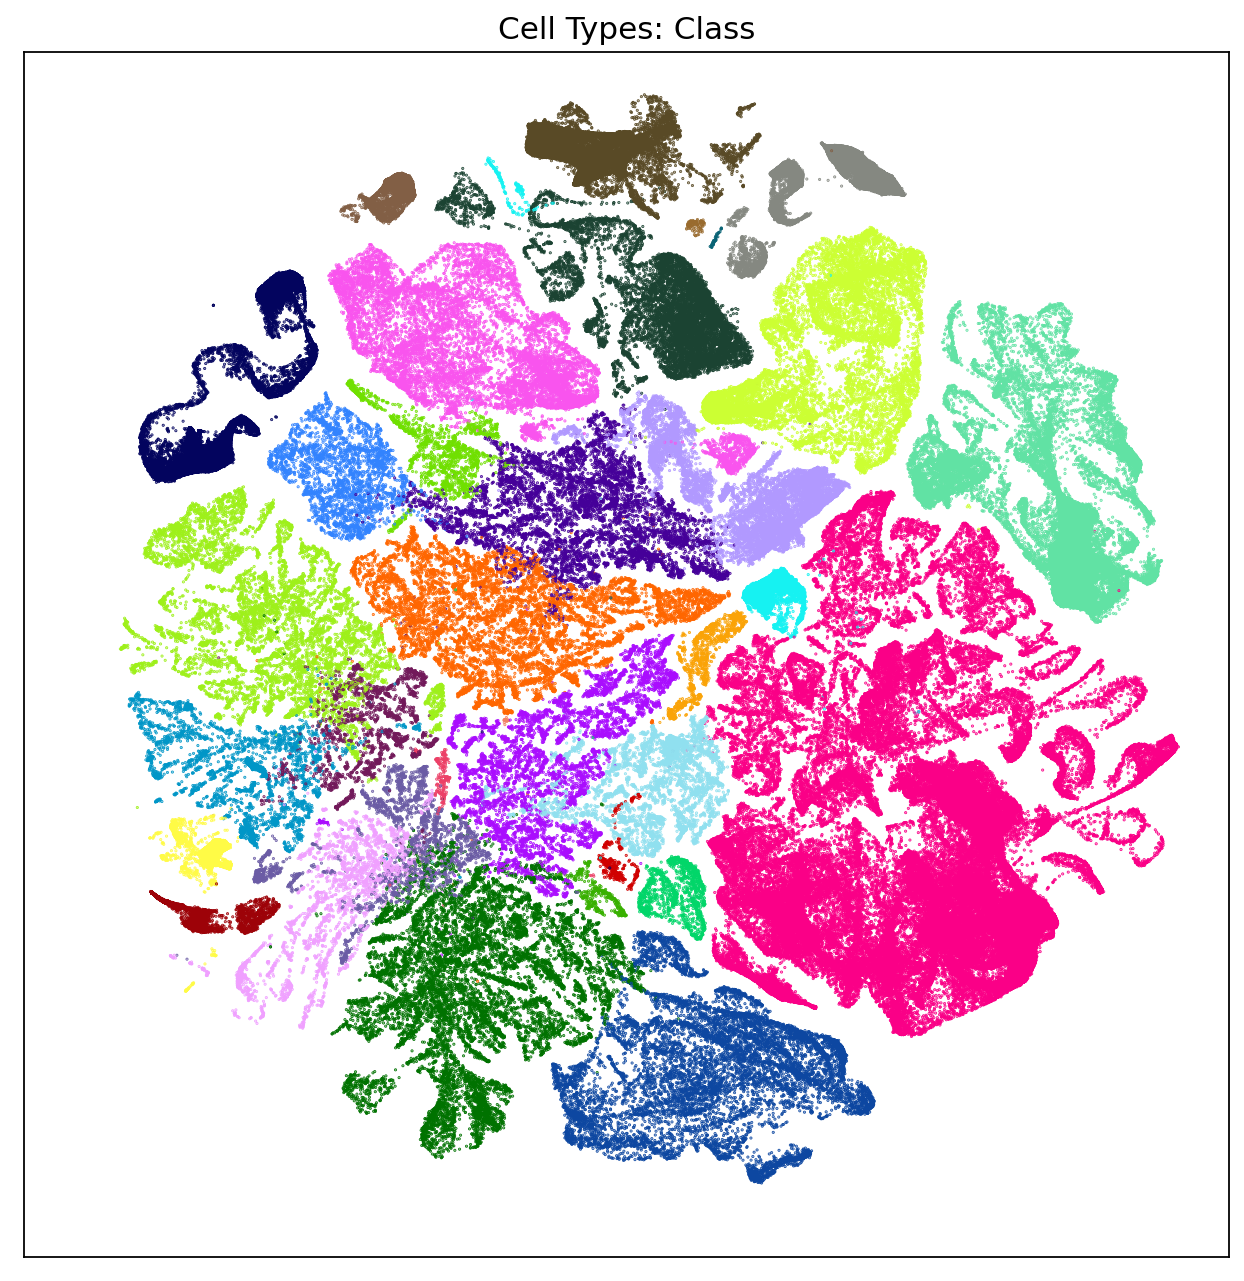

In [73]:
fig, ax = plot_umap(
    cell_subsampled["x"], cell_subsampled["y"], cc=cell_subsampled["class_color"]
)
res = ax.set_title("Cell Types: Class")
plt.show()

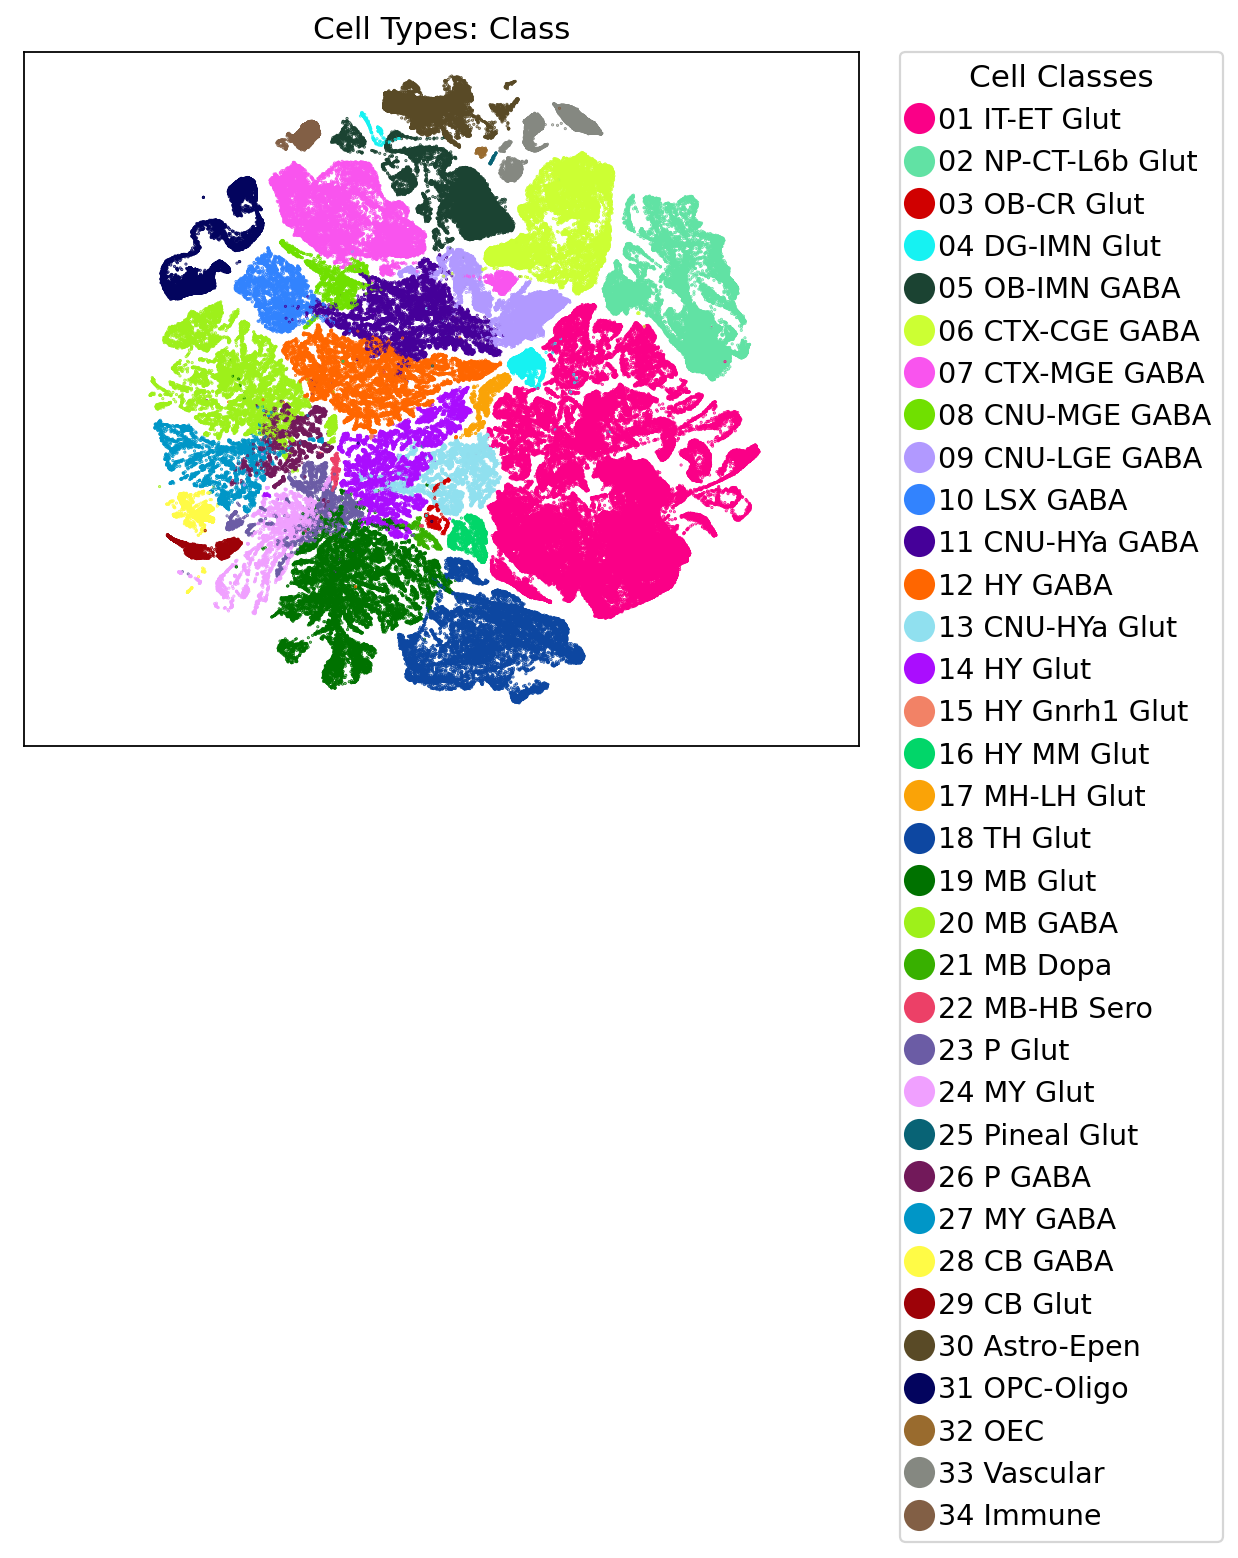

In [52]:
fig, ax = plot_umap(
    cell_subsampled["x"],
    cell_subsampled["y"],
    cc=cell_subsampled["class_color"],
    legend_classes=cell_subsampled["class"],
)
res = ax.set_title("Cell Types: Class")
plt.show()

# Load matrices

## 10Xv2

### Merge adatas

In [24]:
data_dir_10Xv2 = os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "download",
    "expression_matrices",
    "WMB-10Xv2",
    "20230630",
)
data_dir_10Xv2

'/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/download/expression_matrices/WMB-10Xv2/20230630'

In [25]:
x = os.listdir(data_dir_10Xv2)
x = [file for file in x if "raw.h5ad" in file]
x

['WMB-10Xv2-MB-raw.h5ad',
 'WMB-10Xv2-OLF-raw.h5ad',
 'WMB-10Xv2-Isocortex-2-raw.h5ad',
 'WMB-10Xv2-Isocortex-4-raw.h5ad',
 'WMB-10Xv2-TH-raw.h5ad',
 'WMB-10Xv2-Isocortex-3-raw.h5ad',
 'WMB-10Xv2-CTXsp-raw.h5ad',
 'WMB-10Xv2-HY-raw.h5ad',
 'WMB-10Xv2-Isocortex-1-raw.h5ad',
 'WMB-10Xv2-HPF-raw.h5ad']

In [26]:
# load all samples as adata into dict (keys=samplename, values=adata objects)
adatas = {p.split(".")[0]: sc.read_h5ad(os.path.join(data_dir_10Xv2, p)) for p in x}

In [27]:
adatas

{'WMB-10Xv2-MB-raw': AnnData object with n_obs × n_vars = 29891 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
     uns: 'normalization', 'parent', 'parent_layer', 'parent_rows',
 'WMB-10Xv2-OLF-raw': AnnData object with n_obs × n_vars = 193723 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
     uns: 'normalization', 'parent', 'parent_layer', 'parent_rows',
 'WMB-10Xv2-Isocortex-2-raw': AnnData object with n_obs × n_vars = 250040 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol',
 'WMB-10Xv2-Isocortex-4-raw': AnnData object with n_obs × n_vars = 250040 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol',
 'WMB-10Xv2-TH-raw': AnnData object with n_obs × n_vars = 131212 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
    

In [28]:
keys = list(adatas.keys())
keys

['WMB-10Xv2-MB-raw',
 'WMB-10Xv2-OLF-raw',
 'WMB-10Xv2-Isocortex-2-raw',
 'WMB-10Xv2-Isocortex-4-raw',
 'WMB-10Xv2-TH-raw',
 'WMB-10Xv2-Isocortex-3-raw',
 'WMB-10Xv2-CTXsp-raw',
 'WMB-10Xv2-HY-raw',
 'WMB-10Xv2-Isocortex-1-raw',
 'WMB-10Xv2-HPF-raw']

In [29]:
for key in adatas.keys():
    adatas[key].obs["key"] = key

In [30]:
for key in adatas.keys():
    adatas[key].obs.index.name = None

In [31]:
# for key in adatas.keys():
#    adatas[key].obs.index =adatas[key].obs.index + "_" + adatas[key].obs["anatomical_division_label"].astype(str)

In [32]:
adatas[keys[1]].obs.head()

cell_barcode       library_label  \
CCGTGGAAGGACATTA-086_C01  CCGTGGAAGGACATTA  L8TX_190205_01_C08   
TCTCATAGTTTGACAC-086_C01  TCTCATAGTTTGACAC  L8TX_190205_01_C08   
AGTCTTTAGCGTGAAC-113_A01  AGTCTTTAGCGTGAAC  L8TX_190423_01_A07   
TAGGCATAGGCACATG-113_B01  TAGGCATAGGCACATG  L8TX_190423_01_B07   
CTCGTCATCATGGTCA-086_C01  CTCGTCATCATGGTCA  L8TX_190205_01_C08   

                         anatomical_division_label                key  
CCGTGGAAGGACATTA-086_C01                       OLF  WMB-10Xv2-OLF-raw  
TCTCATAGTTTGACAC-086_C01                       OLF  WMB-10Xv2-OLF-raw  
AGTCTTTAGCGTGAAC-113_A01                       OLF  WMB-10Xv2-OLF-raw  
TAGGCATAGGCACATG-113_B01                       OLF  WMB-10Xv2-OLF-raw  
CTCGTCATCATGGTCA-086_C01                       OLF  WMB-10Xv2-OLF-raw

In [33]:
# format var
for key in adatas.keys():
    adatas[key].var["gene_identifier"] = adatas[key].var.index
    adatas[key].var.index = adatas[key].var["gene_symbol"]
    del adatas[key].var["gene_symbol"]

In [34]:
for key in adatas.keys():
    adatas[key].var_names_make_unique()

In [35]:
adatas[key].var.head()

gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

In [36]:
sys.getsizeof(adatas) / 1e9  # GB

3.6e-07

In [37]:
# Merge

In [38]:
merged_v2 = ad.concat(
    adatas, axis=0, join="outer", merge="first"
)  # axis=0 -> concatenate cells while genes are merged

In [39]:
merged_v2

AnnData object with n_obs × n_vars = 1708157 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key'
    var: 'gene_identifier'

In [40]:
merged_v2.obs.index.duplicated().sum()

0

In [41]:
sys.getsizeof(merged_v2) / 1e9  # GB

83.77443095

In [42]:
del adatas
del x
del keys

In [43]:
# save
merged_v2.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v2.h5ad.gz",
    ),
    compression="gzip",
)

In [ ]:
del merged_v2

In [11]:
# load
setdate = "20250128"  # raw
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v2.h5ad.gz",
    )
)

In [12]:
adata.obs.drop(
    ["cell_barcode", "library_label", "anatomical_division_label"], axis=1, inplace=True
)

### Add cell metadata
sample and cell type

In [11]:
# load formatted metadata
setdate = "20250115"
cell_meta = pd.read_csv(
    os.path.join(
        main_dir, "ABCAtlas_Yao2023Nature", setdate + "_meta_data_formatted.csv.gz"
    ),
    index_col=0,
    dtype=str,
)
cell_meta = cell_meta.astype("category")
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [12]:
cell_meta.shape

(4042976, 6)

In [16]:
cell_meta["cell_type_dea"].value_counts(normalize=True)

Neurons-Glut         0.509387
Neurons-Gaba         0.205753
Oligodendrocytes     0.104521
Astrocytes           0.074000
OPCs                 0.030325
ECs                  0.021769
Microglia            0.021329
Neurons-Glyc-Gaba    0.009521
Pericytes            0.006161
SMCs                 0.003615
Neurons-Immature     0.003155
VLMCs                0.002252
Ependymal            0.001528
Neurons-Other        0.001400
BAMs                 0.001392
Neurons-Dopa-Gaba    0.001337
Neurons-Dopa         0.001064
Bergmann             0.000821
OECs                 0.000280
ABCs                 0.000212
Immune-Other         0.000179
Name: cell_type_dea, dtype: float64

In [14]:
adata.obs.head(2)

key
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw

In [15]:
adata.obs.shape

(1708157, 1)

In [16]:
adata.obs = adata.obs.join(cell_meta, how="left")

In [17]:
adata.obs.shape

(1708157, 7)

In [18]:
adata.obs.head(2)

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907  
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499

Note: Some cells contain basic metadata but no cell type annotation. Possibly low quality? Drop those not in metadata. 

In [19]:
adata.obs.index.duplicated().sum()

0

In [20]:
adata.obs.isnull().sum(axis=0)

key                      0
class                 8218
subclass              8218
neurotransmitter    101486
library_method        8218
cell_type_dea         8218
donor_id              8218
dtype: int64

In [21]:
missing_in_meta = adata.obs["donor_id"].isnull()

In [22]:
adata.obs[missing_in_meta].key.value_counts()

WMB-10Xv2-OLF-raw            1541
WMB-10Xv2-Isocortex-1-raw    1264
WMB-10Xv2-Isocortex-4-raw    1256
WMB-10Xv2-HPF-raw            1018
WMB-10Xv2-Isocortex-3-raw     684
WMB-10Xv2-HY-raw              683
WMB-10Xv2-Isocortex-2-raw     680
WMB-10Xv2-TH-raw              657
WMB-10Xv2-CTXsp-raw           325
WMB-10Xv2-MB-raw              110
Name: key, dtype: int64

In [ ]:
adata = adata[~missing_in_meta].copy()

In [ ]:
adata.shape

In [ ]:
adata.obs.head(2)

In [ ]:
adata

In [ ]:
del cell_meta

### Add gene metadata
Contains no additional information

### Export ECs

For additional annotation of EC zonation (separate script)

In [ ]:
adata_vascular = adata[
    adata.obs["cell_type_dea"].isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])
].copy()

In [ ]:
adata_vascular

In [ ]:
# save
adata_vascular.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v2_vascular_subset.h5ad.gz",
    ),
    compression="gzip",
)

In [ ]:
del adata_vascular

### Pseudobulking

In [32]:
adata.X

<1699939x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 6911812740 stored elements in Compressed Sparse Row format>

In [33]:
# check that .X contains raw counts
adata.X.max()

4303.0

In [34]:
adata.obs.head(2)

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907  
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499

In [35]:
# number of cells per group
adata.obs["cell_type_dea"].value_counts()

Neurons-Glut         1272934
Neurons-Gaba          327872
Oligodendrocytes       51363
OPCs                   16146
Astrocytes             12282
Microglia               4760
ECs                     3655
Neurons-Dopa-Gaba       3069
Neurons-Immature        3066
Pericytes               1737
SMCs                     909
VLMCs                    560
Neurons-Other            465
OECs                     433
Ependymal                346
BAMs                     110
Immune-Other              71
Neurons-Glyc-Gaba         66
Neurons-Dopa              62
ABCs                      33
Name: cell_type_dea, dtype: int64

In [36]:
# number of samples per group
for cell_type in adata.obs["cell_type_dea"].cat.categories:
    unique_donors = len(
        adata[adata.obs["cell_type_dea"] == cell_type].obs["donor_id"].cat.categories
    )
    print(f"{unique_donors} {cell_type}")

18 ABCs
95 Astrocytes
26 BAMs
94 ECs
17 Ependymal
27 Immune-Other
93 Microglia
9 Neurons-Dopa
48 Neurons-Dopa-Gaba
96 Neurons-Gaba
96 Neurons-Glut
15 Neurons-Glyc-Gaba
32 Neurons-Immature
8 Neurons-Other
6 OECs
93 OPCs
96 Oligodendrocytes
88 Pericytes
77 SMCs
75 VLMCs


In [37]:
adata.obs["celltypedea_donorid"] = adata.obs.apply(
    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
)

In [38]:
# add number of cells per cell_type-sample group
adata.obs["n_cells"] = adata.obs.groupby(["cell_type_dea", "donor_id"])[
    "donor_id"
].transform("count")

In [39]:
adata.obs[:2]

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  \
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907   
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499   

                          celltypedea_donorid  n_cells  
CGGGTCAGTTAGTGGG-059_E01  Neurons-Gaba_414907     6096  
CGCGTTTGTCTAGGTT-067_B01  Neurons-Glut_423499     2230

In [40]:
ncells = adata.obs.groupby(["cell_type_dea", "donor_id"])["n_cells"].count()
ncells = pd.DataFrame(ncells)

In [41]:
# pd.set_option('display.max_rows', None)
# ncells
# pd.set_option('display.max_rows', 15)

In [42]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("(", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(")", "") for ct in adata.obs["cell_type_dea"]]

In [43]:
# set categorical metadata to be indeed categorical to create pseudobulks
adata.obs["donor_id"] = adata.obs["donor_id"].astype("category")
adata.obs["cell_type_dea"] = adata.obs["cell_type_dea"].astype("category")
adata.obs["celltypedea_donorid"] = adata.obs["celltypedea_donorid"].astype("category")
adata.obs["n_cells"] = adata.obs["n_cells"].astype(int)

- ``pseudobulk_aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [44]:
obs_to_keep = [
    "cell_type_dea",
    "donor_id",
    "celltypedea_donorid",
    "n_cells",
    "library_method",
]

In [45]:
# run pseudobluking
NUM_OF_CELL_PER_DONOR = (
    15  # cell_type-sample combinations must have more cells to not get excluded
)
start_total = time()
cell_type_i = adata.obs["cell_type_dea"].cat.categories[0]
print(
    f"Processing {cell_type_i} (1 out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
)
adata_pb = pseudobulk_aggregate_and_filter(
    adata=adata,
    cell_identity=cell_type_i,
    cell_identity_key="cell_type_dea",
    donor_key="donor_id",
    obs_to_keep=obs_to_keep,
)
for i, cell_type_i in enumerate(adata.obs["cell_type_dea"].cat.categories[1:]):
    print(
        f"Processing {cell_type_i} ({i + 2} out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
    )
    adata_cell_type = pseudobulk_aggregate_and_filter(
        adata=adata,
        cell_identity=cell_type_i,
        cell_identity_key="cell_type_dea",
        donor_key="donor_id",
        obs_to_keep=obs_to_keep,
    )
    adata_pb = adata_pb.concatenate(adata_cell_type)
print(f"Total time: {(time() - start_total) / 60:.1f}m")

Processing ABCs (1 out of 20)...
Dropping the following samples:
['352353', '352357', '366676', '380340', '380345', '381293', '381295', '412866', '414905', '414906', '421226', '425676', '441865', '443005', '443636', '443644', '446701', '446714']
	Processing donor 18 out of 18...

Processing Astrocytes (2 out of 20)...
Dropping the following samples:
['355877', '365616', '366292', '373314', '374159', '374166', '385670', '392473', '396975', '407901', '407902', '410110', '414899', '414901', '426004', '434997', '435849', '439976', '525798']
	Processing donor 95 out of 95...

Processing BAMs (3 out of 20)...
Dropping the following samples:
['352353', '352356', '366678', '374165', '380340', '381293', '395345', '404123', '404124', '404125', '407905', '410108', '414902', '414907', '421226', '435213', '443006', '443636', '446701', '446714', '446716', '456793', '529270', '529272']
	Processing donor 26 out of 26...

Processing ECs (4 out of 20)...
Dropping the following samples:
['355877', '36561

In [46]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [47]:
adata_pb

AnnData object with n_obs × n_vars = 643 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch'

In [48]:
pd.crosstab(adata_pb.obs["cell_type_dea"], adata_pb.obs["batch"])

batch               0   1
cell_type_dea            
Astrocytes         76   0
BAMs                2   0
ECs                61   0
Ependymal           7   0
Immune-Other        1   0
Microglia          53   0
Neurons-Dopa-Gaba  11   0
Neurons-Gaba       96   0
Neurons-Glut       96   0
Neurons-Glyc-Gaba   1   0
Neurons-Immature    9   0
Neurons-Other       5   0
OECs                3   0
OPCs               79   0
Oligodendrocytes   93   0
Pericytes          28   0
SMCs               11   0
VLMCs               0  11

### Explore Covariates
on PCA

In [14]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [15]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [51]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [52]:
adata_pb.obs.head(2)

cell_type_dea donor_id celltypedea_donorid  n_cells  \
celltypedea_donorid                                                       
Astrocytes_352353      Astrocytes   352353   Astrocytes_352353      142   
Astrocytes_352356      Astrocytes   352356   Astrocytes_352356      174   

                    library_method batch  lib_size  log_lib_size  
celltypedea_donorid                                               
Astrocytes_352353            10Xv2     0  434153.0     12.981152  
Astrocytes_352356            10Xv2     0  608173.0     13.318215

In [17]:
sc.pp.pca(adata_pb)

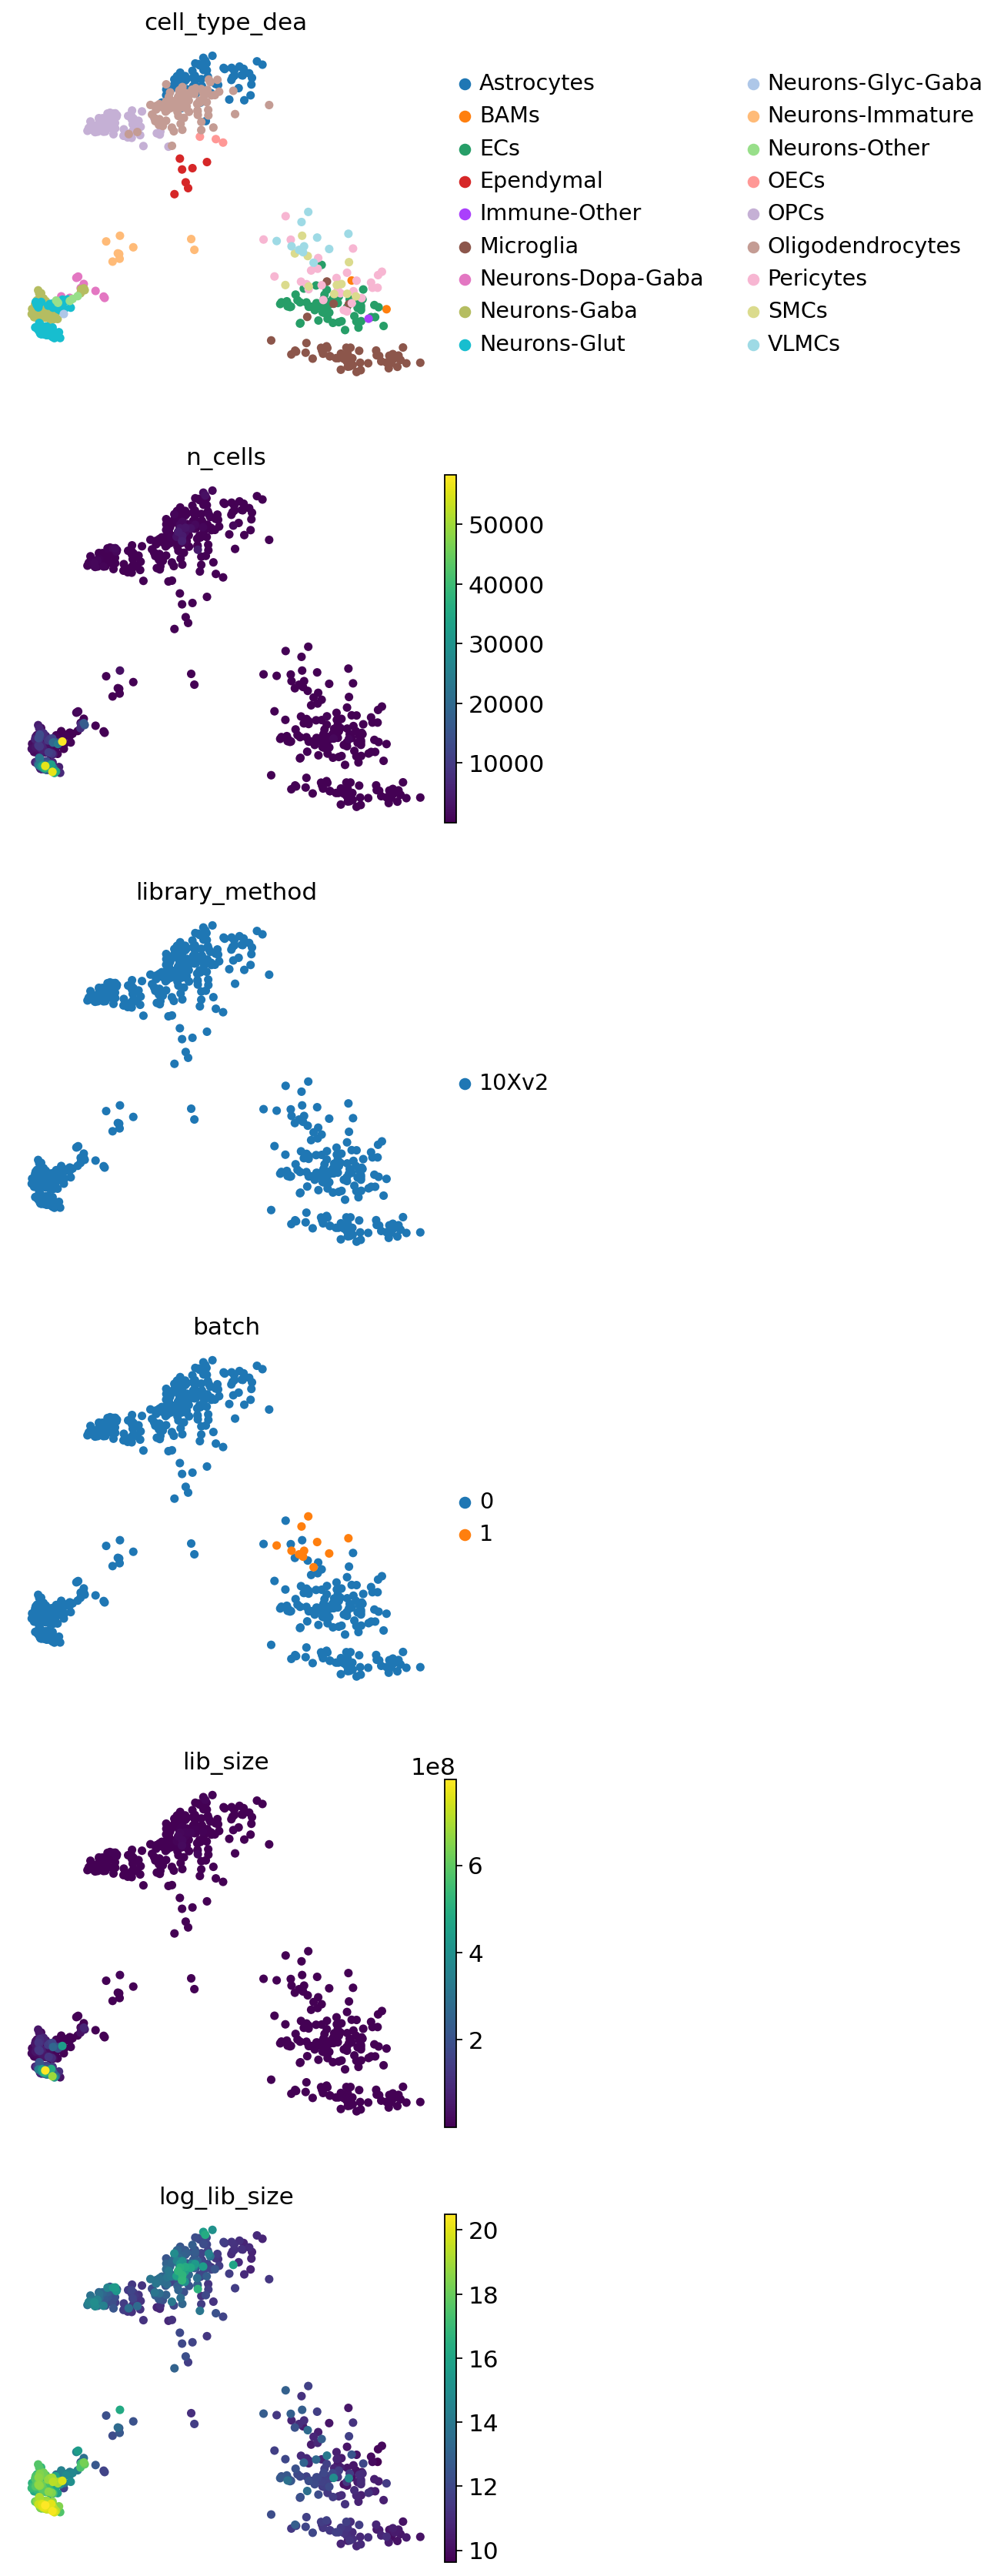

In [18]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=100,
)

In [55]:
adata_pb.X = adata_pb.layers["counts"].copy()

In [56]:
del adata_pb.layers

In [57]:
# del adata_pb.uns['donor_id_colors']
del adata_pb.uns["cell_type_dea_colors"]
del adata_pb.uns["batch_colors"]

In [58]:
adata_pb

AnnData object with n_obs × n_vars = 643 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [59]:
# for compatibility
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(int)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)
adata_pb.obs.index = adata_pb.obs["celltypedea_donorid"]

In [60]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
celltypedea_donorid    category
n_cells                   int64
library_method         category
batch                  category
lib_size                  int64
log_lib_size            float64
dtype: object

In [61]:
adata_pb.X = scipy.sparse.csr_matrix(adata_pb.X, dtype="float32")

In [62]:
adata_pb.X

<643x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 9814306 stored elements in Compressed Sparse Row format>

In [63]:
# save
adata_pb.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v2_pseudobulks.h5ad.gz",
    ),  #
    compression="gzip",
)

In [10]:
# load
setdate = "20250129"  # raw counts, pseudobulks
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v2_pseudobulks.h5ad.gz",
    )
)

In [11]:
adata

AnnData object with n_obs × n_vars = 643 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [12]:
adata.X.max()

21642372.0

In [19]:
del adata
del adata_pb

## 10Xv3

### Merge adatas

In [11]:
data_dir_10Xv3 = os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "download",
    "expression_matrices",
    "WMB-10Xv3",
    "20230630",
)
data_dir_10Xv3

'/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/download/expression_matrices/WMB-10Xv3/20230630'

In [12]:
x = os.listdir(data_dir_10Xv3)
x = [file for file in x if "raw.h5ad" in file]
x

['WMB-10Xv3-HY-raw.h5ad',
 'WMB-10Xv3-CTXsp-raw.h5ad',
 'WMB-10Xv3-MY-raw.h5ad',
 'WMB-10Xv3-P-raw.h5ad',
 'WMB-10Xv3-Isocortex-1-raw.h5ad',
 'WMB-10Xv3-OLF-raw.h5ad',
 'WMB-10Xv3-HPF-raw.h5ad',
 'WMB-10Xv3-MB-raw.h5ad',
 'WMB-10Xv3-Isocortex-2-raw.h5ad',
 'WMB-10Xv3-CB-raw.h5ad',
 'WMB-10Xv3-PAL-raw.h5ad',
 'WMB-10Xv3-STR-raw.h5ad',
 'WMB-10Xv3-TH-raw.h5ad']

In [13]:
# load all samples as adata into dict (keys=samplename, values=adata objects)
adatas = {p.split(".")[0]: sc.read_h5ad(os.path.join(data_dir_10Xv3, p)) for p in x}

In [14]:
adatas

{'WMB-10Xv3-HY-raw': AnnData object with n_obs × n_vars = 162869 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
     uns: 'normalization', 'parent', 'parent_layer', 'parent_rows',
 'WMB-10Xv3-CTXsp-raw': AnnData object with n_obs × n_vars = 78464 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
     uns: 'normalization', 'parent', 'parent_layer', 'parent_rows',
 'WMB-10Xv3-MY-raw': AnnData object with n_obs × n_vars = 192498 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
     uns: 'normalization', 'parent', 'parent_layer', 'parent_rows',
 'WMB-10Xv3-P-raw': AnnData object with n_obs × n_vars = 143661 × 32285
     obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
     var: 'gene_symbol'
     uns: 'normalization', 'parent', 'parent_layer', 'parent_rows',
 'WMB-10Xv3-Isocortex-1-raw': AnnData object with n_obs

In [15]:
keys = list(adatas.keys())
keys

['WMB-10Xv3-HY-raw',
 'WMB-10Xv3-CTXsp-raw',
 'WMB-10Xv3-MY-raw',
 'WMB-10Xv3-P-raw',
 'WMB-10Xv3-Isocortex-1-raw',
 'WMB-10Xv3-OLF-raw',
 'WMB-10Xv3-HPF-raw',
 'WMB-10Xv3-MB-raw',
 'WMB-10Xv3-Isocortex-2-raw',
 'WMB-10Xv3-CB-raw',
 'WMB-10Xv3-PAL-raw',
 'WMB-10Xv3-STR-raw',
 'WMB-10Xv3-TH-raw']

In [16]:
for key in adatas.keys():
    adatas[key].obs["key"] = key

In [17]:
for key in adatas.keys():
    adatas[key].obs.index.name = None

In [18]:
# for key in adatas.keys():
#    adatas[key].obs.index =adatas[key].obs.index + "_" + adatas[key].obs["anatomical_division_label"].astype(str)

In [19]:
adatas[keys[1]].obs.head()

cell_barcode       library_label  \
GCCCGAAGTCAGTTTG-344_C04  GCCCGAAGTCAGTTTG  L8TX_200827_01_E10   
AGGTTACTCGCGCCAA-332_B01  AGGTTACTCGCGCCAA  L8TX_200820_01_D01   
ATGAGGGAGTGTTCCA-332_A01  ATGAGGGAGTGTTCCA  L8TX_200820_01_E02   
CATAGACAGTCTAACC-299_B02  CATAGACAGTCTAACC  L8TX_200723_01_G09   
GAGTTACCATGACGAG-299_A02  GAGTTACCATGACGAG  L8TX_200723_01_F09   

                         anatomical_division_label                  key  
GCCCGAAGTCAGTTTG-344_C04                     CTXsp  WMB-10Xv3-CTXsp-raw  
AGGTTACTCGCGCCAA-332_B01                     CTXsp  WMB-10Xv3-CTXsp-raw  
ATGAGGGAGTGTTCCA-332_A01                     CTXsp  WMB-10Xv3-CTXsp-raw  
CATAGACAGTCTAACC-299_B02                     CTXsp  WMB-10Xv3-CTXsp-raw  
GAGTTACCATGACGAG-299_A02                     CTXsp  WMB-10Xv3-CTXsp-raw

In [20]:
# format var
for key in adatas.keys():
    adatas[key].var["gene_identifier"] = adatas[key].var.index
    adatas[key].var.index = adatas[key].var["gene_symbol"]
    del adatas[key].var["gene_symbol"]

In [21]:
for key in adatas.keys():
    adatas[key].var_names_make_unique()

In [22]:
adatas[key].var.head()

gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

In [23]:
sys.getsizeof(adatas) / 1e9  # GB

6.4e-07

In [24]:
# Merge

In [25]:
merged_v3 = ad.concat(
    adatas, axis=0, join="outer", merge="first"
)  # axis=0 -> concatenate cells while genes are merged

In [26]:
merged_v3

AnnData object with n_obs × n_vars = 2349544 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key'
    var: 'gene_identifier'

In [27]:
merged_v3.obs.index.duplicated().sum()

0

In [28]:
sys.getsizeof(merged_v3) / 1e9  # GB

142.113155675

In [29]:
del adatas
del x
del keys

In [30]:
merged_v3.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3.h5ad.gz",
    ),
    compression="gzip",
)

In [31]:
del merged_v3

In [11]:
# load
setdate = "20250129"  # raw
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v3.h5ad.gz",
    )
)

In [12]:
adata.obs.drop(
    ["cell_barcode", "library_label", "anatomical_division_label"], axis=1, inplace=True
)

In [13]:
adata

AnnData object with n_obs × n_vars = 2349544 × 32285
    obs: 'key'
    var: 'gene_identifier'

### Add cell metadata
sample and cell type

In [14]:
# load formatted metadata
setdate = "20250115"
cell_meta = pd.read_csv(
    os.path.join(
        main_dir, "ABCAtlas_Yao2023Nature", setdate + "_meta_data_formatted.csv.gz"
    ),
    index_col=0,
    dtype=str,
)
cell_meta = cell_meta.astype("category")
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [15]:
adata.obs.head(2)

key
TGAGGGACACCAAATC-392_A04  WMB-10Xv3-HY-raw
AACGGGAGTACGTGAG-469_A03  WMB-10Xv3-HY-raw

In [16]:
adata.obs.shape

(2349544, 1)

In [17]:
adata.obs = adata.obs.join(cell_meta, how="left")

In [18]:
adata.obs.shape

(2349544, 7)

In [19]:
adata.obs.head(2)

key            class  \
TGAGGGACACCAAATC-392_A04  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   
AACGGGAGTACGTGAG-469_A03  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   

                                               subclass neurotransmitter  \
TGAGGGACACCAAATC-392_A04  079 CEA-BST Six3 Cyp26b1 Gaba             GABA   
AACGGGAGTACGTGAG-469_A03  079 CEA-BST Six3 Cyp26b1 Gaba             GABA   

                         library_method cell_type_dea donor_id  
TGAGGGACACCAAATC-392_A04          10Xv3  Neurons-Gaba   546895  
AACGGGAGTACGTGAG-469_A03          10Xv3  Neurons-Gaba   556848

In [20]:
# split adata to manage memory
# ensuring all cells from the same donor (donor_id) stay in the same group

In [21]:
donors = adata.obs["donor_id"].unique()
len(donors)

223

In [22]:
n_splits = 6

In [23]:
def split_adata(adata, n_splits=n_splits):
    groups = {i: [] for i in range(n_splits)}
    for i, donor in enumerate(donors):
        groups[i % n_splits].append(donor)
    return [adata[adata.obs["donor_id"].isin(groups[i])] for i in range(n_splits)]


adatas = split_adata(adata)

In [24]:
adatas

[View of AnnData object with n_obs × n_vars = 406825 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 374334 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 427456 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 375452 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 378609 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n

In [25]:
del adata

Note: Some cells contain basic metadata but no cell type annotation. Possibly low quality? Drop those not in metadata. 

In [26]:
for i in range(n_splits):
    print(adatas[i].obs.index.duplicated().sum())

0
0
0
0
0
0


In [27]:
for i in range(n_splits):
    print(i)
    print(adatas[i].obs.isnull().sum(axis=0))

0
key                      0
class                    0
subclass                 0
neurotransmitter    186310
library_method           0
cell_type_dea            0
donor_id                 0
dtype: int64
1
key                      0
class                    0
subclass                 0
neurotransmitter    166929
library_method           0
cell_type_dea            0
donor_id                 0
dtype: int64
2
key                      0
class                    0
subclass                 0
neurotransmitter    198776
library_method           0
cell_type_dea            0
donor_id                 0
dtype: int64
3
key                      0
class                 8194
subclass              8194
neurotransmitter    174624
library_method        8194
cell_type_dea         8194
donor_id              8194
dtype: int64
4
key                      0
class                    0
subclass                 0
neurotransmitter    114982
library_method           0
cell_type_dea            0
donor_id            

In [28]:
for i in range(n_splits):
    print(i)
    missing_in_meta = adatas[i].obs["donor_id"].isnull()
    print(adatas[i].obs[missing_in_meta].key.value_counts())
    adatas[i] = adatas[i][~missing_in_meta].copy()

0
WMB-10Xv3-CB-raw             0
WMB-10Xv3-CTXsp-raw          0
WMB-10Xv3-HPF-raw            0
WMB-10Xv3-HY-raw             0
WMB-10Xv3-Isocortex-1-raw    0
WMB-10Xv3-Isocortex-2-raw    0
WMB-10Xv3-MB-raw             0
WMB-10Xv3-MY-raw             0
WMB-10Xv3-OLF-raw            0
WMB-10Xv3-P-raw              0
WMB-10Xv3-PAL-raw            0
WMB-10Xv3-STR-raw            0
WMB-10Xv3-TH-raw             0
Name: key, dtype: int64
1
WMB-10Xv3-CB-raw             0
WMB-10Xv3-CTXsp-raw          0
WMB-10Xv3-HPF-raw            0
WMB-10Xv3-HY-raw             0
WMB-10Xv3-Isocortex-1-raw    0
WMB-10Xv3-Isocortex-2-raw    0
WMB-10Xv3-MB-raw             0
WMB-10Xv3-MY-raw             0
WMB-10Xv3-OLF-raw            0
WMB-10Xv3-P-raw              0
WMB-10Xv3-PAL-raw            0
WMB-10Xv3-STR-raw            0
WMB-10Xv3-TH-raw             0
Name: key, dtype: int64
2
WMB-10Xv3-CB-raw             0
WMB-10Xv3-CTXsp-raw          0
WMB-10Xv3-HPF-raw            0
WMB-10Xv3-HY-raw             0
WMB-10Xv3-Isocor

In [29]:
adatas

[AnnData object with n_obs × n_vars = 406825 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 374334 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 427456 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 367258 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 378609 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 386868 × 32285
     obs: 'key', 

In [30]:
del cell_meta

### Add gene metadata
No additional information

In [31]:
# gene_meta.head(2)

In [32]:
# adata.var.head(2)

In [33]:
# adata.var.join(gene_meta, how="left")

In [34]:
# adata.var.head(2)

### Export ECs

For additional annotation of EC zonation (separate script)

In [35]:
filtered_adatas = {}

In [36]:
for i in range(n_splits):
    filtered_adatas[i] = adatas[i][
        adatas[i]
        .obs["cell_type_dea"]
        .isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])
    ].copy()

In [37]:
adata_merged = sc.concat(list(filtered_adatas.values()))

In [39]:
adata_merged

AnnData object with n_obs × n_vars = 130599 × 32285
    obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'

In [40]:
adata_merged.obs.cell_type_dea.value_counts()

ECs          84356
Pericytes    23170
SMCs         13705
VLMCs         8544
ABCs           824
Name: cell_type_dea, dtype: int64

In [41]:
# save
adata_merged.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3_vascular_subset.h5ad.gz",
    ),
    compression="gzip",
)

In [42]:
del adata_merged
del filtered_adatas

### Pseudobulking

In [35]:
adatas[i].X

<386868x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 1963287548 stored elements in Compressed Sparse Row format>

In [36]:
# check that .X contains raw counts
for i in range(n_splits):
    print(adatas[i].X.max())

16928.0
34575.0
10250.0
11869.0
14814.0
15060.0


In [37]:
adatas[i].obs.head(2)

key            class  \
TACCTGCAGTTCCTGA-354_A06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   
AACCTTTGTAACTGCT-354_C06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   

                                               subclass neurotransmitter  \
TACCTGCAGTTCCTGA-354_A06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   
AACCTTTGTAACTGCT-354_C06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   

                         library_method cell_type_dea donor_id  
TACCTGCAGTTCCTGA-354_A06          10Xv3  Neurons-Gaba   540230  
AACCTTTGTAACTGCT-354_C06          10Xv3  Neurons-Gaba   540230

In [38]:
# number of cells per group
for i in range(n_splits):
    print(i)
    print(adatas[i].obs["cell_type_dea"].value_counts())

0
Neurons-Glut         117694
Neurons-Gaba          92459
Oligodendrocytes      62915
Astrocytes            57961
OPCs                  19193
ECs                   17666
Microglia             14682
Neurons-Glyc-Gaba      6176
Pericytes              4773
SMCs                   2797
Neurons-Immature       2154
VLMCs                  1975
Ependymal              1799
BAMs                   1207
Neurons-Other          1094
Neurons-Dopa            811
Neurons-Dopa-Gaba       701
ABCs                    289
Bergmann                280
Immune-Other            155
OECs                     44
Name: cell_type_dea, dtype: int64
1
Neurons-Glut         116545
Neurons-Gaba          85243
Oligodendrocytes      61790
Astrocytes            50883
ECs                   15635
OPCs                  14929
Microglia             13033
Pericytes              3982
Neurons-Glyc-Gaba      3264
SMCs                   2101
Neurons-Immature       1293
VLMCs                  1212
Ependymal              1074
BAMs      

In [39]:
# number of samples per group
for i in range(n_splits):
    print(i)
    for cell_type in adatas[i].obs["cell_type_dea"].cat.categories:
        unique_donors = len(
            adatas[i][adatas[i].obs["cell_type_dea"] == cell_type]
            .obs["donor_id"]
            .cat.categories
        )
        print(f"{unique_donors} {cell_type}")

0
10 ABCs
38 Astrocytes
30 BAMs
4 Bergmann
38 ECs
23 Ependymal
26 Immune-Other
37 Microglia
8 Neurons-Dopa
10 Neurons-Dopa-Gaba
38 Neurons-Gaba
38 Neurons-Glut
17 Neurons-Glyc-Gaba
12 Neurons-Immature
20 Neurons-Other
1 OECs
38 OPCs
38 Oligodendrocytes
36 Pericytes
35 SMCs
36 VLMCs
1
10 ABCs
37 Astrocytes
28 BAMs
5 Bergmann
37 ECs
22 Ependymal
20 Immune-Other
37 Microglia
7 Neurons-Dopa
11 Neurons-Dopa-Gaba
37 Neurons-Gaba
37 Neurons-Glut
14 Neurons-Glyc-Gaba
10 Neurons-Immature
21 Neurons-Other
2 OECs
37 OPCs
37 Oligodendrocytes
34 Pericytes
34 SMCs
29 VLMCs
2
13 ABCs
37 Astrocytes
30 BAMs
3 Bergmann
36 ECs
18 Ependymal
20 Immune-Other
36 Microglia
8 Neurons-Dopa
9 Neurons-Dopa-Gaba
35 Neurons-Gaba
37 Neurons-Glut
15 Neurons-Glyc-Gaba
13 Neurons-Immature
17 Neurons-Other
1 OECs
37 OPCs
37 Oligodendrocytes
36 Pericytes
31 SMCs
36 VLMCs
3
10 ABCs
36 Astrocytes
25 BAMs
4 Bergmann
35 ECs
20 Ependymal
25 Immune-Other
35 Microglia
9 Neurons-Dopa
7 Neurons-Dopa-Gaba
35 Neurons-Gaba
36 Neuron

In [40]:
# add number of cells per cell_type-sample group
for i in range(n_splits):
    adatas[i].obs["n_cells"] = (
        adatas[i]
        .obs.groupby(["cell_type_dea", "donor_id"])["donor_id"]
        .transform("count")
    )

In [41]:
adatas[i].obs[:2]

key            class  \
TACCTGCAGTTCCTGA-354_A06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   
AACCTTTGTAACTGCT-354_C06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   

                                               subclass neurotransmitter  \
TACCTGCAGTTCCTGA-354_A06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   
AACCTTTGTAACTGCT-354_C06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   

                         library_method cell_type_dea donor_id  n_cells  
TACCTGCAGTTCCTGA-354_A06          10Xv3  Neurons-Gaba   540230     5514  
AACCTTTGTAACTGCT-354_C06          10Xv3  Neurons-Gaba   540230     5514

In [42]:
ncells = adatas[i].obs.groupby(["cell_type_dea", "donor_id"])["n_cells"].count()
ncells = pd.DataFrame(ncells)

In [43]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 15)

In [44]:
ncells

n_cells
cell_type_dea donor_id         
ABCs          426001          0
              450095          0
              457909          0
              464328          0
              468425          0
...                         ...
VLMCs         565914         31
              574606         82
              574607         26
              604611          1
              621073         40

[777 rows x 1 columns]

In [45]:
# clean up the cell type names to avoid Python to R conversion issues
for i in range(n_splits):
    adatas[i].obs["cell_type_dea"] = [
        ct.replace(" ", "_") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace("/", "_") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace(" ", "_") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace("+", "") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace("(", "") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace(")", "") for ct in adatas[i].obs["cell_type_dea"]
    ]

In [46]:
# set categorical metadata to be indeed categorical to create pseudobulks
for i in range(n_splits):
    adatas[i].obs["donor_id"] = adatas[i].obs["donor_id"].astype("category")
    adatas[i].obs["cell_type_dea"] = adatas[i].obs["cell_type_dea"].astype("category")
    adatas[i].obs["n_cells"] = adatas[i].obs["n_cells"].astype(int)

- ``pseudobulk_aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [47]:
obs_to_keep = [
    "cell_type_dea",
    "donor_id",
    "n_cells",
    "library_method",
]  # , "celltypedea_donorid"

In [48]:
NUM_OF_CELL_PER_DONOR = (
    15  # cell_type-sample combinations must have more cells to not get excluded
)

In [49]:
def process_split(adata_split, obs_to_keep=obs_to_keep):
    adata_pb_split = None

    for j, cell_type_i in enumerate(adata_split.obs["cell_type_dea"].cat.categories):
        print(
            f"Processing {cell_type_i} ({j + 1} out of {len(adata_split.obs['cell_type_dea'].cat.categories)})"
        )

        adata_cell_type = pseudobulk_aggregate_and_filter(
            adata=adata_split,
            cell_identity=cell_type_i,
            cell_identity_key="cell_type_dea",
            donor_key="donor_id",
            obs_to_keep=obs_to_keep,
        )

        if adata_pb_split is None:
            adata_pb_split = adata_cell_type
        else:
            adata_pb_split = adata_pb_split.concatenate(adata_cell_type)

        del adata_cell_type

    return adata_pb_split

In [50]:
start_total = time()
for i, adata_split in enumerate(adatas):
    # for i, adata_split in enumerate(adatas[4:], start=4): # Starting from i = 4 manually
    print(f"Processing split {i + 1} out of {len(adatas)}...")
    adata_pb_split = process_split(adata_split, obs_to_keep)
    adata_pb_split.X = scipy.sparse.csr_matrix(adata_pb_split.X, dtype="float32")
    adata_pb_split.obs["n_cells"] = adata_pb_split.obs["n_cells"].astype(int)
    output_path = os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        f"{date.today().strftime('%Y%m%d')}_merged_v3_pseudobulks_split_{i}.h5ad.gz",
    )
    adata_pb_split.write(output_path, compression="gzip")
    del adata_pb_split
print(f"Total time: {(time() - start_total) / 60:.1f}m")

Processing split 1 out of 6...
Processing ABCs (1 out of 21)
Dropping the following samples:
['546811', '550850', '553680', '554922', '556113', '562458', '565824']
	Processing donor 10 out of 10...

Processing Astrocytes (2 out of 21)
Dropping the following samples:
['462433', '531163']
	Processing donor 38 out of 38...

Processing BAMs (3 out of 21)
Dropping the following samples:
['473981', '482568', '494814', '505950', '511243', '561536', '563792', '565824', '608856']
	Processing donor 30 out of 30...

Processing Bergmann (4 out of 21)
Dropping the following samples:
['556113', '572421']
	Processing donor 4 out of 4...

Processing ECs (5 out of 21)
Dropping the following samples:
['462433', '473085', '482568', '500027', '511243', '529271', '531163', '531952', '566076', '608856']
	Processing donor 38 out of 38...

Processing Ependymal (6 out of 21)
Dropping the following samples:
['473085', '482568', '510544', '511243', '529271', '540565', '546895', '548212', '553680', '554815', '561

In [51]:
del adatas

In [55]:
# load splits
setdate = "20250129"
files = sorted(
    glob(
        os.path.join(
            main_dir,
            "ABCAtlas_Yao2023Nature",
            "anndata-objects",
            f"{setdate}_merged_v3_pseudobulks_split_*.h5ad.gz",
        )
    )
)

In [56]:
files

['/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_0.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_1.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_2.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_3.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_4.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_5.h5ad.gz']

In [57]:
# merge splits
adata_merged = sc.concat([sc.read_h5ad(f) for f in files])

In [58]:
adata_merged

AnnData object with n_obs × n_vars = 2072 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch'

In [59]:
len(adata_merged.obs["donor_id"].unique())

222

In [60]:
import scipy.sparse

adata_merged.X = scipy.sparse.csr_matrix(adata_merged.X, dtype="float32")

In [61]:
adata_merged.X

<2072x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 38029010 stored elements in Compressed Sparse Row format>

In [62]:
adata_merged.X.max()

13331419.0

In [63]:
adata_merged.obs.dtypes

cell_type_dea     category
donor_id          category
n_cells              int64
library_method    category
batch             category
dtype: object

In [64]:
# save merged
adata_merged.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3_pseudobulks_temp.h5ad.gz",
    ),
    compression="gzip",
)

In [110]:
# load merged
setdate = "20250129"  # raw temp
adata_merged = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v3_pseudobulks_temp.h5ad.gz",
    )
)

In [111]:
adata_merged

AnnData object with n_obs × n_vars = 2072 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch'

In [ ]:
# Delete temp split files
! rm "$main_dir"/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks_split_[0-9]*.h5ad.gz

In [112]:
adata_pb = adata_merged.copy()

In [113]:
del adata_merged

In [114]:
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs.apply(
    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)

In [115]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [116]:
adata_pb

AnnData object with n_obs × n_vars = 2072 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch', 'celltypedea_donorid'

In [117]:
pd.crosstab(adata_pb.obs["cell_type_dea"], adata_pb.obs["batch"])

batch                0    1
cell_type_dea              
ABCs                15    0
Astrocytes         208    0
BAMs                93    0
Bergmann            15    0
ECs                151    0
Ependymal           43    0
Immune-Other         5    0
Microglia          133    0
Neurons-Dopa        21    0
Neurons-Dopa-Gaba   20    0
Neurons-Gaba       197    0
Neurons-Glut       221    0
Neurons-Glyc-Gaba   81    0
Neurons-Immature    43    0
Neurons-Other       59    0
OECs                 8    0
OPCs               217    0
Oligodendrocytes   222    0
Pericytes          113    0
SMCs               102    0
VLMCs                0  105

### Explore Covariates
on PCA

In [118]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [119]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [120]:
adata_pb.X.max()

11.94506

In [121]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [122]:
adata_pb.obs.head(2)

cell_type_dea donor_id  n_cells library_method batch  \
celltypedea_donorid                                                        
ABCs_546813                  ABCs   546813      109          10Xv3     0   
ABCs_548212                  ABCs   548212      130          10Xv3     0   

                    celltypedea_donorid   lib_size  log_lib_size  
celltypedea_donorid                                               
ABCs_546813                 ABCs_546813  1523589.0     14.236579  
ABCs_548212                 ABCs_548212  2175399.0     14.592723

In [123]:
sc.pp.pca(adata_pb)

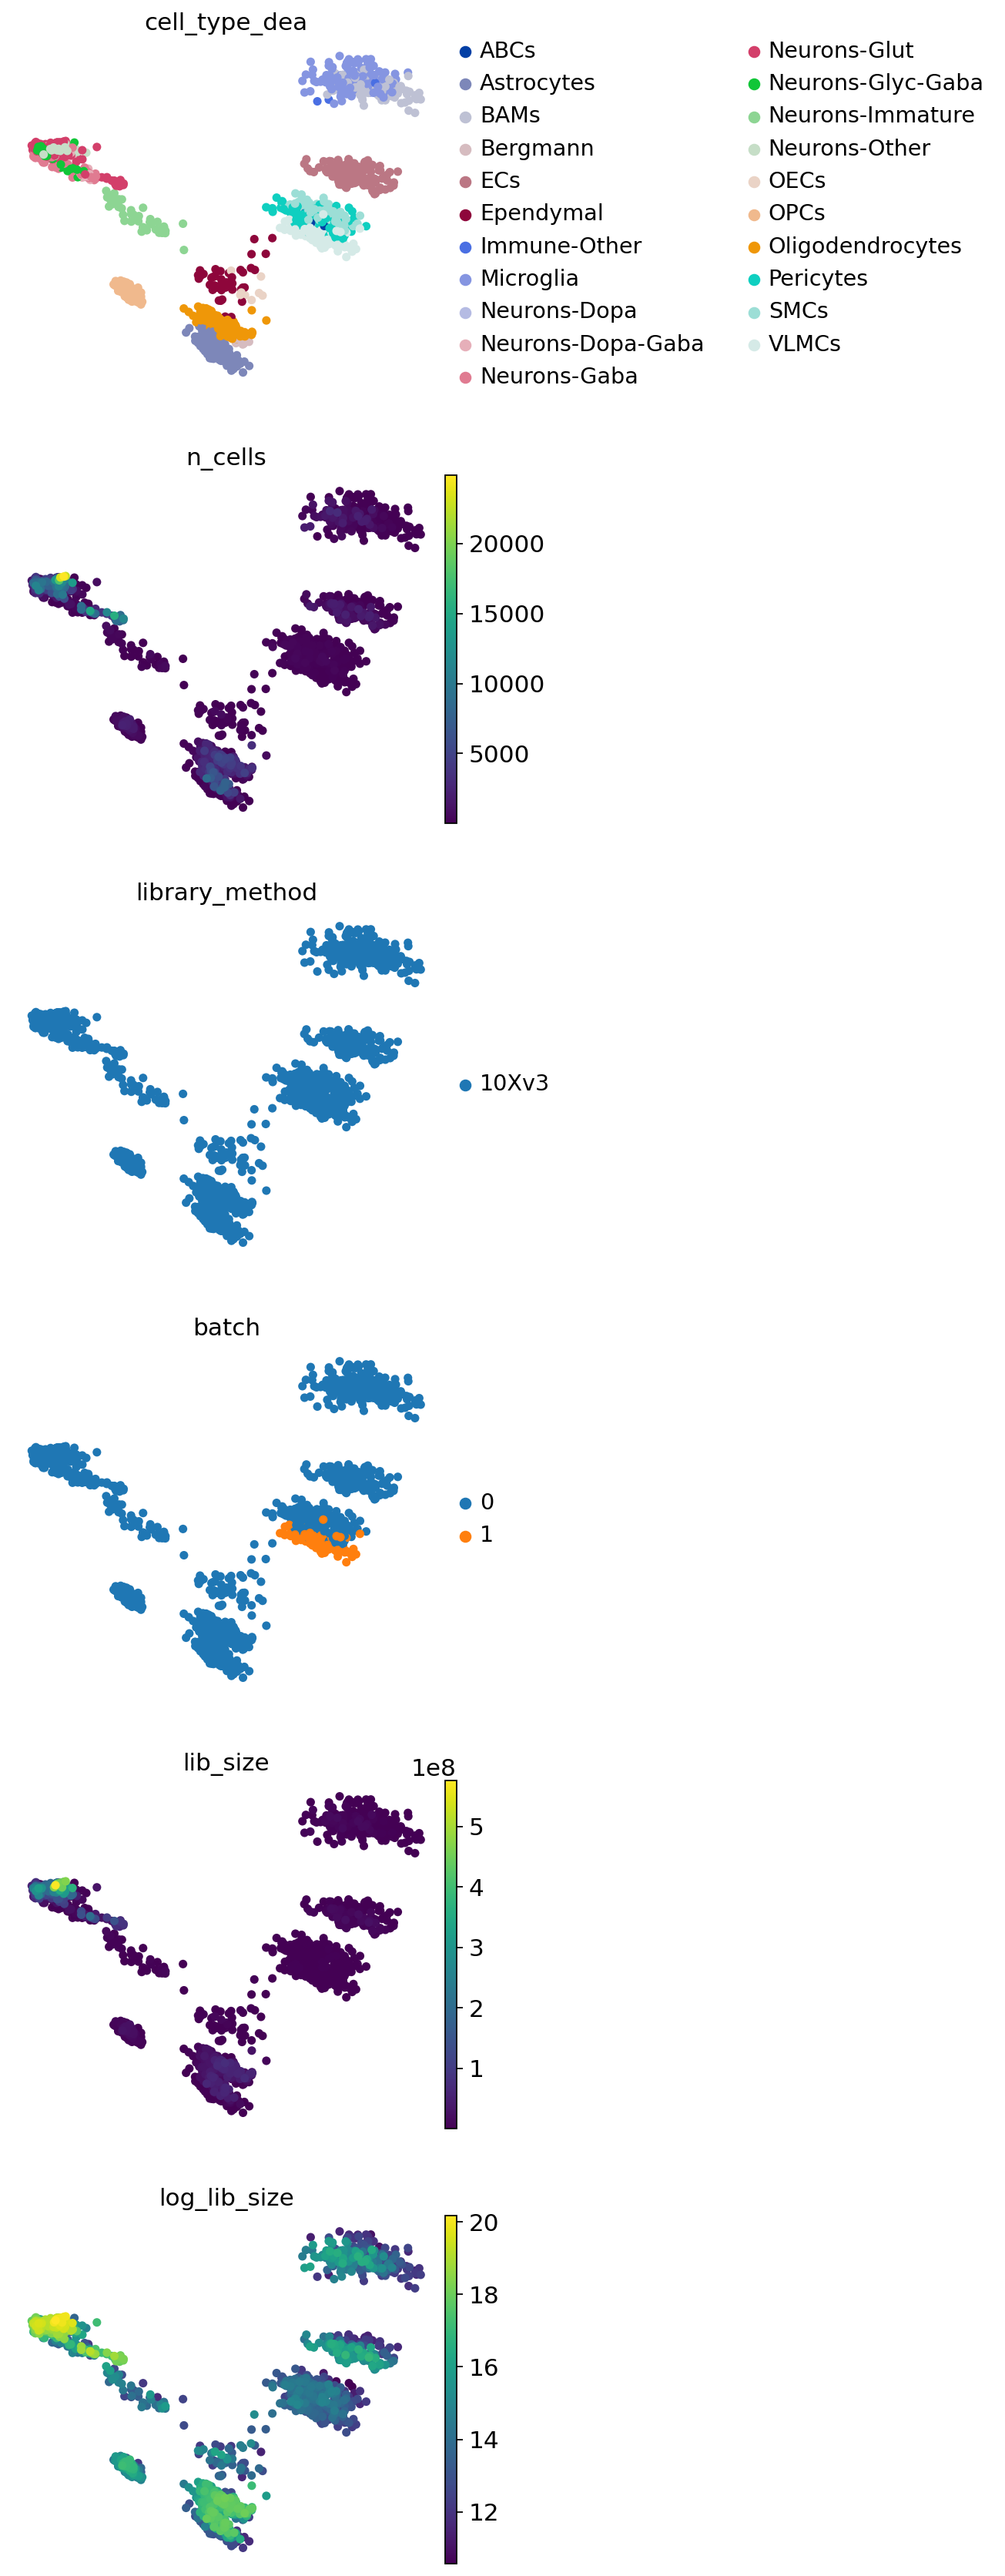

In [124]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=100,
)

In [125]:
adata_pb.X = adata_pb.layers["counts"].copy()

In [126]:
del adata_pb.layers

In [127]:
del adata_pb.uns["cell_type_dea_colors"]
del adata_pb.uns["batch_colors"]

In [128]:
adata_pb

AnnData object with n_obs × n_vars = 2072 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch', 'celltypedea_donorid', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [129]:
adata_pb.X.max()

13331419.0

In [130]:
# for compatibility
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(int)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)
adata_pb.obs.index = adata_pb.obs["celltypedea_donorid"]

In [131]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
n_cells                   int64
library_method         category
batch                  category
celltypedea_donorid    category
lib_size                  int64
log_lib_size            float64
dtype: object

In [132]:
os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "anndata-objects",
    date.today().strftime("%Y%m%d") + "_merged_v3_pseudobulks.h5ad.gz",
)

'/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks.h5ad.gz'

In [133]:
# save
adata_pb.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3_pseudobulks.h5ad.gz",
    ),  #
    compression="gzip",
)

In [134]:
# load
setdate = "20250129"  # raw counts, pseudobulks
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v3_pseudobulks.h5ad.gz",
    )
)

In [135]:
adata

AnnData object with n_obs × n_vars = 2072 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch', 'celltypedea_donorid', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [136]:
adata.X.max()

13331419.0

## 10XMulti

Single file only

In [47]:
data_dir_10XMulti = os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "download",
    "expression_matrices",
    "WMB-10XMulti",
    "20230830",
)
data_dir_10XMulti

'/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/download/expression_matrices/WMB-10XMulti/20230830'

In [48]:
x = os.listdir(data_dir_10XMulti)
x = [file for file in x if "raw.h5ad" in file]
x

['WMB-10XMulti-raw.h5ad']

In [54]:
# load all samples as adata into dict (keys=samplename, values=adata objects)
adata_10XMulti = sc.read_h5ad(os.path.join(data_dir_10XMulti, x[0]))

In [55]:
adata_10XMulti

AnnData object with n_obs × n_vars = 1687 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [56]:
key = "WMB-10XMulti-raw"

In [57]:
adata_10XMulti.obs["key"] = key

In [58]:
adata_10XMulti.obs.index.name = None

In [59]:
adata_10XMulti.obs.head()

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   
AACTGTTCAGCAGGTA-1143_A05  AACTGTTCAGCAGGTA  L8XR_220317_03_H06   
AAGTTTGTCATAACTG-1143_A05  AAGTTTGTCATAACTG  L8XR_220317_03_H06   
AATTTGGTCAAACCGT-1143_A05  AATTTGGTCAAACCGT  L8XR_220317_03_H06   

                          anatomical_division_label               key  
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw  
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw  
AACTGTTCAGCAGGTA-1143_A05                        CB  WMB-10XMulti-raw  
AAGTTTGTCATAACTG-1143_A05                        CB  WMB-10XMulti-raw  
AATTTGGTCAAACCGT-1143_A05                        CB  WMB-10XMulti-raw

In [60]:
adata_10XMulti.var

gene_symbol
gene_identifier               
ENSMUSG00000051951        Xkr4
ENSMUSG00000089699      Gm1992
ENSMUSG00000102331     Gm19938
ENSMUSG00000102343     Gm37381
ENSMUSG00000025900         Rp1
...                        ...
ENSMUSG00000095523  AC124606.1
ENSMUSG00000095475  AC133095.2
ENSMUSG00000094855  AC133095.1
ENSMUSG00000095019  AC234645.1
ENSMUSG00000095041  AC149090.1

[32285 rows x 1 columns]

In [61]:
# format var
adata_10XMulti.var["gene_identifier"] = adata_10XMulti.var.index.astype("str")
adata_10XMulti.var.index = adata_10XMulti.var["gene_symbol"].astype("str")
del adata_10XMulti.var["gene_symbol"]

In [62]:
adata_10XMulti.var_names_make_unique()

In [63]:
adata_10XMulti.var.head()

gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

In [64]:
[gene for gene in adata_10XMulti.var_names if "Ptp4a1" in gene]

['Ptp4a1', 'Ptp4a1-1']

In [65]:
adata_10XMulti.var.dtypes

gene_identifier    object
dtype: object

In [66]:
adata_10XMulti.obs.index.duplicated().sum()

0

In [67]:
sys.getsizeof(adata_10XMulti) / 1e9  # GB

0.133725167

In [68]:
adata = adata_10XMulti.copy()

In [69]:
del adata_10XMulti

### Add cell metadata
sample and cell type

In [70]:
# load formatted metadata
setdate = "20250115"
cell_meta = pd.read_csv(
    os.path.join(
        main_dir, "ABCAtlas_Yao2023Nature", setdate + "_meta_data_formatted.csv.gz"
    ),
    index_col=0,
    dtype=str,
)
cell_meta = cell_meta.astype("category")
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [71]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw  
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw

In [72]:
adata.obs.shape

(1687, 4)

In [73]:
adata.obs = adata.obs.join(cell_meta, how="left")

In [74]:
adata.obs.shape

(1687, 10)

In [75]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id  
AACATCATCAGCCAAT-1143_A05   621255  
AACTAGCTCCGTTAAA-1143_A05   621255

Note: Some cells contain basic metadata but no cell type annotation. Possibly low quality? Drop those not in metadata. 

In [76]:
adata.obs.index.duplicated().sum()

0

In [77]:
adata.obs.isnull().sum(axis=0)

cell_barcode                 0
library_label                0
anatomical_division_label    0
key                          0
class                        0
subclass                     0
neurotransmitter             0
library_method               0
cell_type_dea                0
donor_id                     0
dtype: int64

In [78]:
missing_in_meta = adata.obs["donor_id"].isnull()

In [79]:
adata.obs[missing_in_meta].key.value_counts()

Series([], Name: key, dtype: int64)

In [80]:
adata = adata[~missing_in_meta]

In [81]:
adata.shape

(1687, 32285)

In [82]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id  
AACATCATCAGCCAAT-1143_A05   621255  
AACTAGCTCCGTTAAA-1143_A05   621255

In [83]:
adata

View of AnnData object with n_obs × n_vars = 1687 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
    var: 'gene_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [84]:
del cell_meta

### Add gene metadata
No additional information

In [85]:
# gene_meta.head(2)

In [86]:
# adata.var.head(2)

In [87]:
# adata.var.join(gene_meta, how="left")

In [88]:
# adata.var.head(2)

### Export ECs

For additional annotation of EC zonation (separate script)

In [89]:
adata_vascular = adata[
    adata.obs["cell_type_dea"].isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])
].copy()

In [90]:
adata_vascular

AnnData object with n_obs × n_vars = 0 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
    var: 'gene_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

Note: No vascular cells

### Pseudobulking

In [56]:
adata.X

<1687x32285 sparse matrix of type '<class 'numpy.float64'>'
	with 10725202 stored elements in Compressed Sparse Row format>

In [57]:
# check that .X contains raw counts
adata.X.max()

11779.0

In [58]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label                key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-log2   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-log2   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id  
AACATCATCAGCCAAT-1143_A05   621255  
AACTAGCTCCGTTAAA-1143_A05   621255

In [59]:
# number of cells per group
adata.obs["cell_type_dea"].value_counts()

Neurons-Glut         653
Neurons-Glyc-Gaba    397
Neurons-Gaba         363
Neurons-Other        274
Name: cell_type_dea, dtype: int64

In [60]:
# number of samples per group
for cell_type in adata.obs["cell_type_dea"].cat.categories:
    unique_donors = len(
        adata[adata.obs["cell_type_dea"] == cell_type].obs["donor_id"].cat.categories
    )
    print(f"{unique_donors} {cell_type}")

19 Neurons-Gaba
19 Neurons-Glut
17 Neurons-Glyc-Gaba
16 Neurons-Other


In [61]:
adata.obs["celltypedea_donorid"] = adata.obs.apply(
    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
)

In [62]:
# add number of cells per cell_type-sample group
adata.obs["n_cells"] = adata.obs.groupby(["cell_type_dea", "donor_id"])[
    "donor_id"
].transform("count")

In [63]:
adata.obs[:2]

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label                key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-log2   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-log2   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id   celltypedea_donorid  n_cells  
AACATCATCAGCCAAT-1143_A05   621255   Neurons-Glut_621255        6  
AACTAGCTCCGTTAAA-1143_A05   621255  Neurons-Other_621255       16

In [64]:
ncells = adata.obs.groupby(["cell_type_dea", "donor_id"])["n_cells"].count()
ncells = pd.DataFrame(ncells)

In [65]:
# pd.set_option('display.max_rows', None)
# ncells
# pd.set_option('display.max_rows', 15)

In [66]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("(", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(")", "") for ct in adata.obs["cell_type_dea"]]

In [67]:
# set categorical metadata to be indeed categorical to create pseudobulks
adata.obs["donor_id"] = adata.obs["donor_id"].astype("category")
adata.obs["cell_type_dea"] = adata.obs["cell_type_dea"].astype("category")
adata.obs["celltypedea_donorid"] = adata.obs["celltypedea_donorid"].astype("category")
adata.obs["n_cells"] = adata.obs["n_cells"].astype(int)

- ``pseudobulk_aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [68]:
obs_to_keep = [
    "cell_type_dea",
    "donor_id",
    "celltypedea_donorid",
    "n_cells",
    "library_method",
]

In [69]:
# run pseudobluking
NUM_OF_CELL_PER_DONOR = (
    15  # cell_type-sample combinations must have more cells to not get excluded
)
cell_type_i = adata.obs["cell_type_dea"].cat.categories[0]
print(
    f"Processing {cell_type_i} (1 out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
)
adata_pb = pseudobulk_aggregate_and_filter(
    adata=adata,
    cell_identity=cell_type_i,
    cell_identity_key="cell_type_dea",
    donor_key="donor_id",
    obs_to_keep=obs_to_keep,
)
for i, cell_type_i in enumerate(adata.obs["cell_type_dea"].cat.categories[1:]):
    print(
        f"Processing {cell_type_i} ({i + 2} out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
    )
    adata_cell_type = pseudobulk_aggregate_and_filter(
        adata=adata,
        cell_identity=cell_type_i,
        cell_identity_key="cell_type_dea",
        donor_key="donor_id",
        obs_to_keep=obs_to_keep,
    )
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Neurons-Gaba (1 out of 4)...
Dropping the following samples:
['582994', '603642', '608214', '620191', '621249', '621251', '621254', '623065', '624066', '625151', '626936']
	Processing donor 19 out of 19...

Processing Neurons-Glut (2 out of 4)...
Dropping the following samples:
['580195', '582994', '603642', '614000', '620191', '621255', '621256', '624069', '624070', '625151', '626943', '641405']
	Processing donor 19 out of 19...

Processing Neurons-Glyc-Gaba (3 out of 4)...
Dropping the following samples:
['614000', '620191', '621251', '621252', '621253', '624069', '625156', '626936', '641405', '643089']
	Processing donor 17 out of 17...

Processing Neurons-Other (4 out of 4)...
Dropping the following samples:
['582994', '582996', '603642', '620183', '620184', '620191', '621251', '621252', '624069', '626936']
	Processing donor 16 out of 16...



In [70]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [71]:
adata_pb

AnnData object with n_obs × n_vars = 28 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch'

In [72]:
adata_pb.X.max()

355074.0

In [73]:
pd.crosstab(adata_pb.obs["cell_type_dea"], adata_pb.obs["batch"])

batch              0  1
cell_type_dea          
Neurons-Gaba       8  0
Neurons-Glut       7  0
Neurons-Glyc-Gaba  7  0
Neurons-Other      0  6

### Explore Covariates
on PCA

In [25]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [26]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [27]:
adata_pb.layers["log1p_norm"].max()

11.246059

In [28]:
adata_pb.layers["counts"].max()

355074.0

In [107]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [29]:
adata_pb.obs.head(2)

cell_type_dea donor_id  celltypedea_donorid  n_cells  \
celltypedea_donorid                                                        
Neurons-Gaba_614000  Neurons-Gaba   614000  Neurons-Gaba_614000       26   
Neurons-Gaba_620183  Neurons-Gaba   620183  Neurons-Gaba_620183       17   

                    library_method batch  lib_size  log_lib_size  
celltypedea_donorid                                               
Neurons-Gaba_614000   10xRSeq_Mult     0   1922755     14.469270  
Neurons-Gaba_620183   10xRSeq_Mult     0    362386     12.800465

In [30]:
sc.pp.pca(adata_pb)

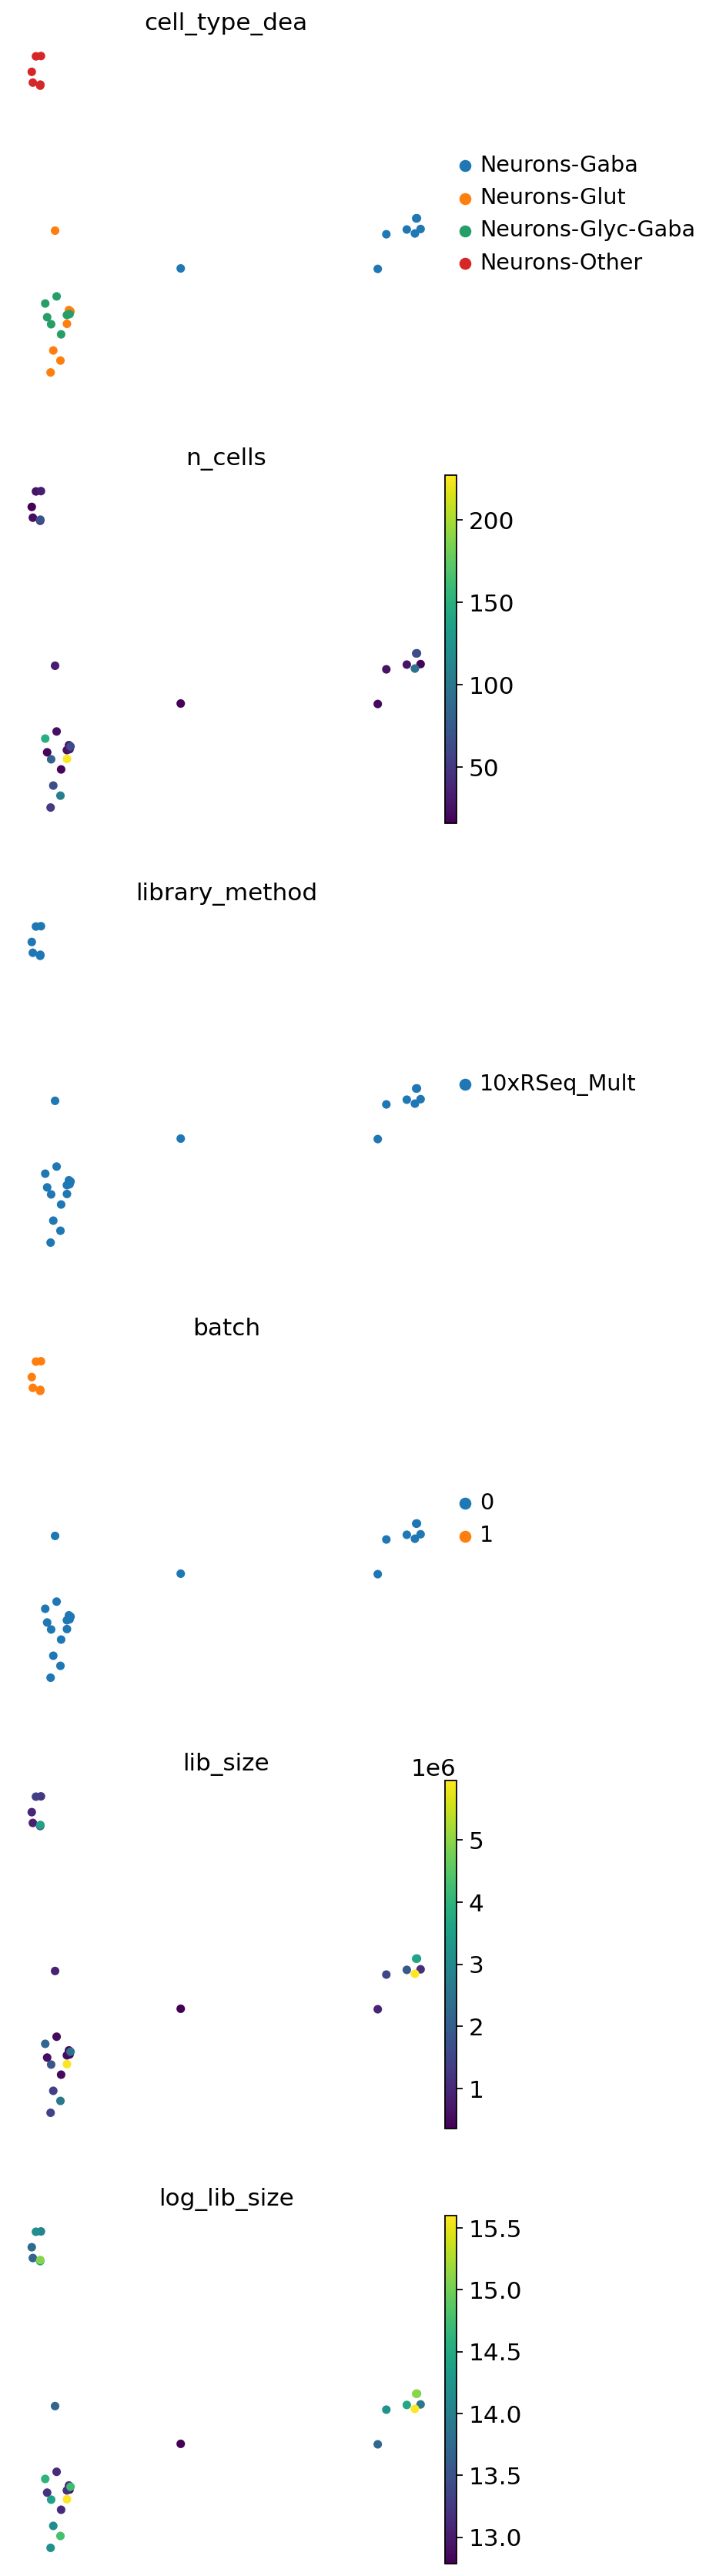

In [31]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=100,
)

In [111]:
adata_pb.X = adata_pb.layers["counts"].copy()

In [112]:
del adata_pb.layers

In [113]:
del adata_pb.uns["cell_type_dea_colors"]
del adata_pb.uns["batch_colors"]

In [114]:
adata_pb

AnnData object with n_obs × n_vars = 28 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [115]:
# for compatibility
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(int)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)
adata_pb.obs.index = adata_pb.obs["celltypedea_donorid"]

In [116]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
celltypedea_donorid    category
n_cells                   int64
library_method         category
batch                  category
lib_size                  int64
log_lib_size            float64
dtype: object

In [117]:
import scipy.sparse

adata_pb.X = scipy.sparse.csr_matrix(adata_pb.X, dtype="float32")

In [118]:
adata_pb.X

<28x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 473963 stored elements in Compressed Sparse Row format>

In [119]:
adata_pb.X.max()

355074.0

In [120]:
# save
adata_pb.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_Multi_pseudobulks.h5ad.gz",
    ),  #
    compression="gzip",
)

In [21]:
# load
setdate = "20250129"  # raw counts, pseudobulks
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_Multi_pseudobulks.h5ad.gz",
    )
)

In [22]:
adata

AnnData object with n_obs × n_vars = 28 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
adata.X.max()

355074.0

# Merge pseudobulk datasets

## Merge

In [10]:
# Find all pseudobulk files
pattern = os.path.join(main_dir, "**", "*_pseudobulks.h5ad.gz")
files = glob(pattern, recursive=True)
files

['/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v2_pseudobulks.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_v3_pseudobulks.h5ad.gz',
 '/cluster2/sfrerich/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/anndata-objects/20250129_merged_Multi_pseudobulks.h5ad.gz']

In [11]:
# Load and merge all files
adatas = [sc.read_h5ad(f) for f in files]
merged = adatas[0].concatenate(adatas[1:])

In [12]:
total_input_obs = sum(adata.n_obs for adata in adatas)
assert merged.n_obs == total_input_obs, (
    f"Merged obs ({merged.n_obs}) != sum of input obs ({total_input_obs})"
)

In [13]:
del adatas

In [14]:
merged

AnnData object with n_obs × n_vars = 2743 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [15]:
merged.X.max()

21642372.0

In [16]:
merged.obs.index = merged.obs.celltypedea_donorid

In [17]:
# save
merged.write(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_pseudobulks_all.h5ad.gz",
    ),  #
    compression="gzip",
)

In [10]:
# load
setdate = "20250129"  # raw counts, pseudobulks, all merged
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_pseudobulks_all.h5ad.gz",
    )
)

In [11]:
adata

AnnData object with n_obs × n_vars = 2743 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [12]:
adata.X.max()

21642372.0

In [13]:
adata_pb = adata.copy()

## Explore Covariates
on PCA

In [14]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [15]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [16]:
adata_pb.layers["log1p_norm"].max()

12.278938

In [17]:
adata_pb.layers["counts"].max()

21642372.0

In [19]:
sc.pp.pca(adata_pb)

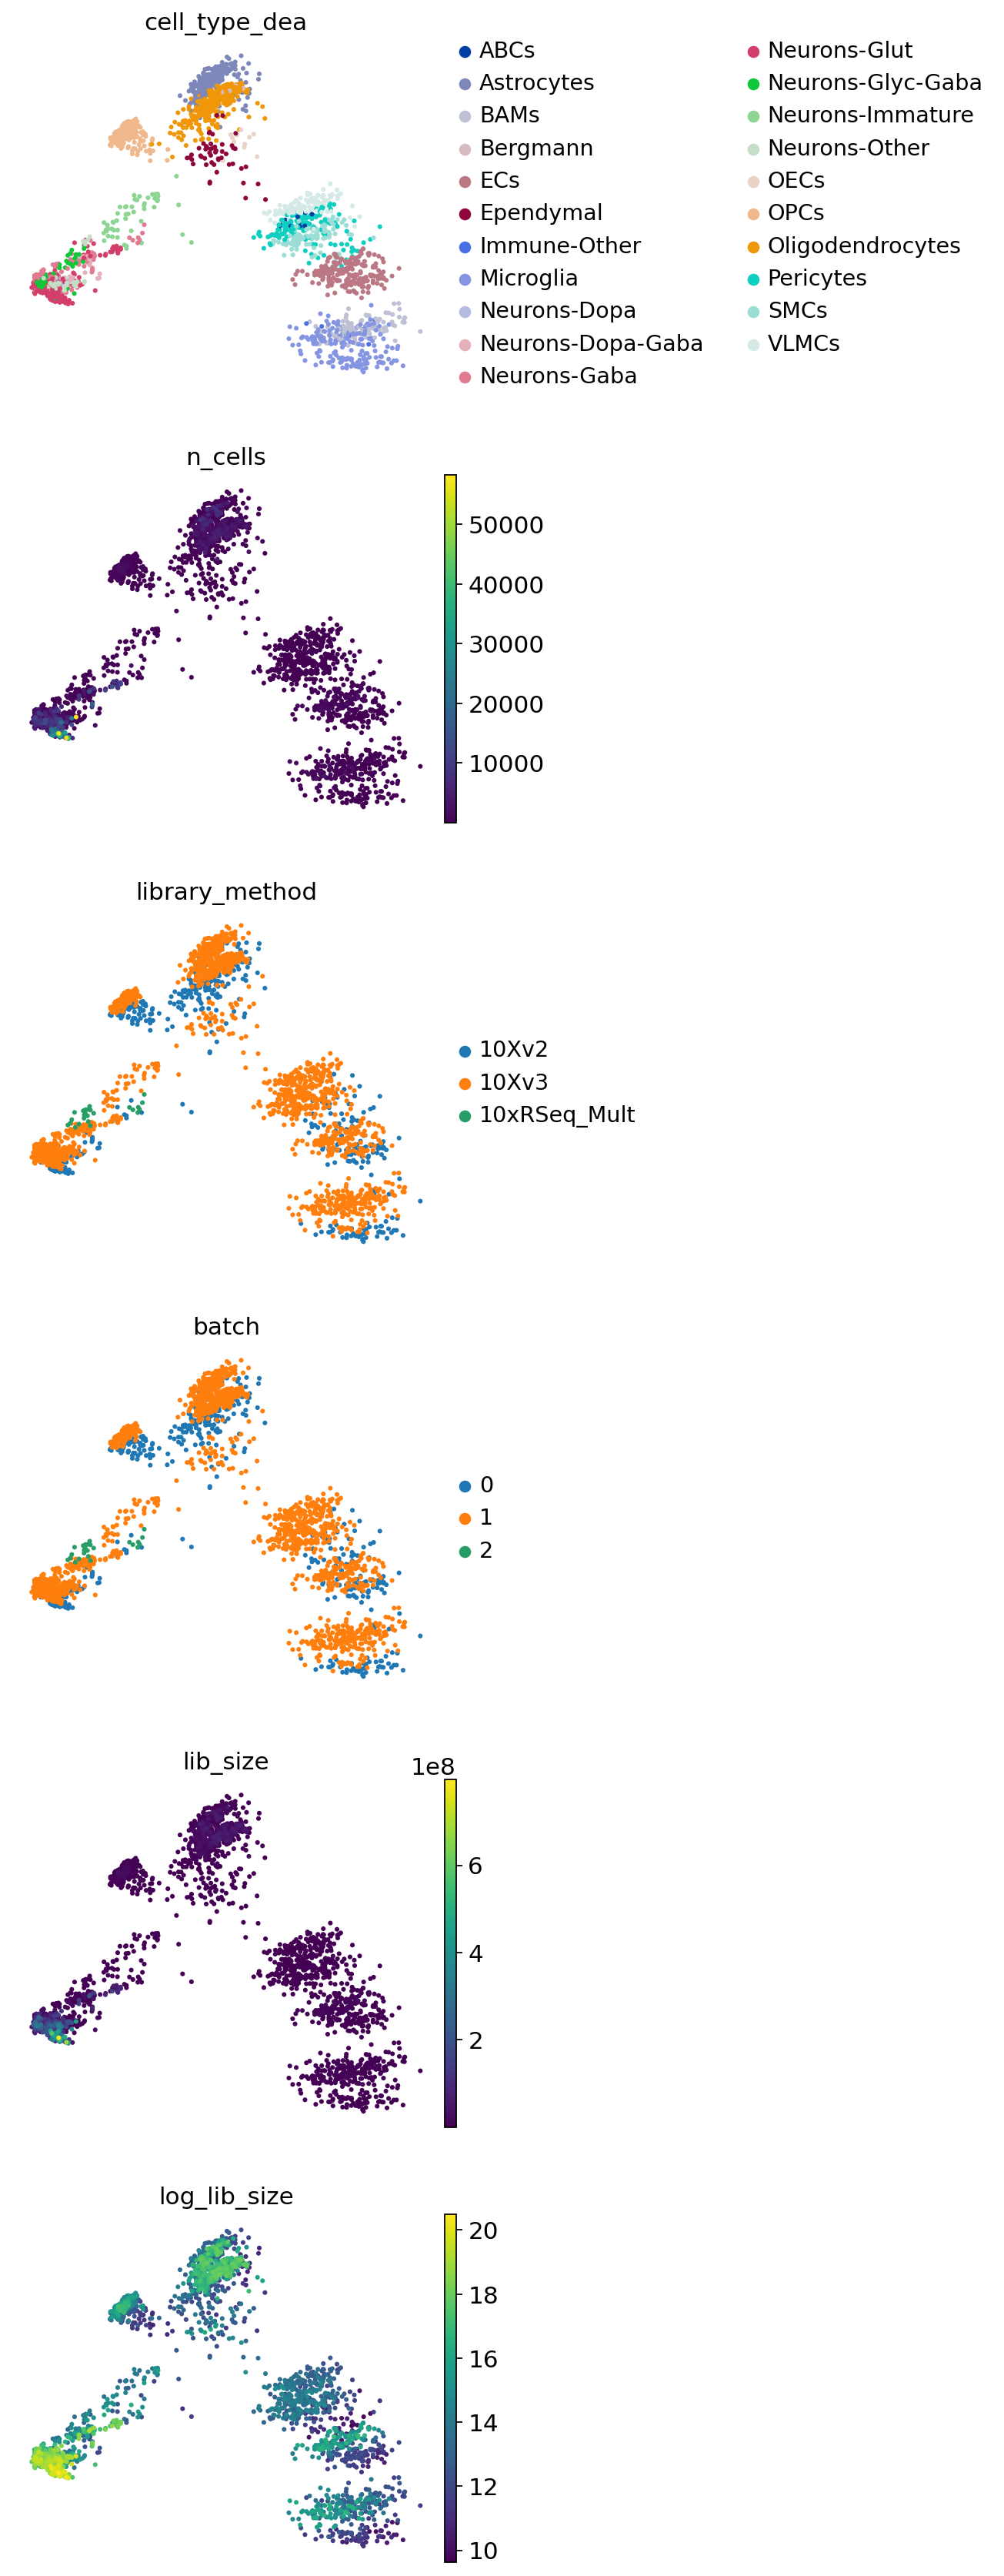

In [23]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=30,
)